QUESTION 1: Factors that impact salary
To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:

NLP
Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
Ensemble methods and decision tree models
SVM models
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. Communication of your process is key. Note that most listings DO NOT come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('salary_df_car_fut.csv')

## 1.1: First level cleaning and engineering of non-text heavy columns

In [3]:
df = df.replace('NONE',np.nan)
df = df.drop('Unnamed: 0', axis=1)
df.head()

Company  \
0                      SKILLSFUTURE SINGAPORE AGENCY   
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   

                                               Title  \
0  Executive, (Quality Management Division) (6-mo...   
1                                   Business Analyst   
2                                  Software Engineer   
3                            Data Analytics –Manager   
4                                    Research Fellow   

                                           Address  \
0  ONE MARINA BOULEVARD, 1 MARINA BOULEVARD 018989   
1                             1 DEPOT CLOSE 109841   
2             GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3     MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                              NaN   

                         Emp_type                Seniority  \
0                        Contract                      NaN   
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   

                 Industry           Salary  \
0  Public / Civil Service              NaN   
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   

                                      Responsibility  \
0  Roles & ResponsibilitiesResponsibilities\r\n\r...   
1  Roles & ResponsibilitiesHP is the world’s lead...   
2  Roles & ResponsibilitiesResponsibilities:   De...   
3  Roles & Responsibilities Advisory - Consulting...   
4  Roles & ResponsibilitiesData Scientist / Progr...   

                                        Requirements  
0                                                NaN  
1  RequirementsEducation and Experience Required:...  
2  RequirementsRequirements:   Minimum B.S. degre...  
3  Requirements  A good Degree in a quantitative ...  
4  Requirements Doctorate degree in a relevant fi...

In [4]:
#drop rows without salary
df = df[~df['Salary'].isnull()]
#drop duplicates
df = df.drop_duplicates()

In [5]:
df.info()
#1246 usable rows left

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 1 to 1625
Data columns (total 9 columns):
Company           1246 non-null object
Title             1246 non-null object
Address           935 non-null object
Emp_type          1246 non-null object
Seniority         1236 non-null object
Industry          1246 non-null object
Salary            1246 non-null object
Responsibility    1246 non-null object
Requirements      1227 non-null object
dtypes: object(9)
memory usage: 97.3+ KB


In [6]:
#clean salary into upper, lower & avg salary
import re
df['Salary_lower'] = df['Salary'].map(lambda x: x.replace('$','').replace(',','').split('to')[0]).astype('float')
df['Salary_upper'] = df['Salary'].map(lambda x: x.replace('$','').replace(',','').split('to')[1]).astype('float')
df['Salary_avg'] = (df['Salary_lower']+df['Salary_upper'])/2

count      1246.000000
mean       9315.684992
std       17810.283889
min           1.000000
25%        5000.000000
50%        6500.000000
75%        9000.000000
max      300000.000000
Name: Salary_avg, dtype: float64


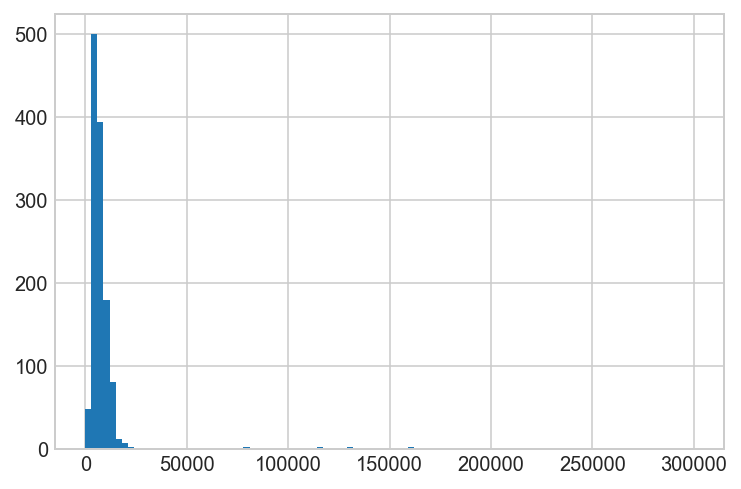

In [7]:
print(df['Salary_avg'].describe()) 
df['Salary_avg'].hist(bins=100)
#higher avg salary are annual salary data, has to (/12) normalize to monthly

In [8]:
#https://www.morganmckinley.com.sg/article/2017-it-permanent-salary-survey-guide
#avg salary level for director level is SGD25,000 monthly. We can safely convert those above 1 stdev
print np.median(df['Salary_avg'])+np.std(df['Salary_avg'])
len(df[df['Salary_avg']>np.median(df['Salary_avg'])+np.std(df['Salary_avg'])])

24303.135470256846


25

In [9]:
df = df[df['Salary_avg']>1] #remove outlier 1
df['Salary_avg'] = df['Salary_avg'].map(lambda x: x/12 if x>np.median(df['Salary_avg'])+np.std(df['Salary_avg']) else x) #normalise to monthly

In [10]:
df['Salary_avg']
df['Salary_avg_cat'] = df['Salary_avg'].apply(lambda x: 0 if x < 5000 else 2 if x > 9000 else 1)
df[['Salary_avg','Salary_avg_cat']]

Salary_avg  Salary_avg_cat
1     10650.000000               2
2      6200.000000               1
3      7850.000000               1
4      4500.000000               0
6      9000.000000               1
7     11250.000000               2
8      3750.000000               0
9      5500.000000               1
11     9166.666667               2
12     4250.000000               0
13     5500.000000               1
17     4000.000000               0
18     5175.000000               1
19     7500.000000               1
22     5150.000000               1
23     5000.000000               1
24     3750.000000               0
25     4500.000000               0
26     3750.000000               0
27     4500.000000               0
31     5000.000000               1
32     5000.000000               1
34     6500.000000               1
35     8500.000000               1
36     3250.000000               0
38     8250.000000               1
39     3500.000000               0
40     4000.000000               0
41    15666.500000               2
42     3250.000000               0
...            ...             ...
1589   6250.000000               1
1590   8000.000000               1
1591   6750.000000               1
1592   4200.000000               0
1593   9500.000000               2
1594   7900.000000               1
1595  13300.000000               2
1597   5900.000000               1
1598   6000.000000               1
1599   4500.000000               0
1600   4750.000000               0
1601   5250.000000               1
1603   7000.000000               1
1604   4500.000000               0
1606  11500.000000               2
1608   9750.000000               2
1609   5000.000000               1
1611   5000.000000               1
1612   4350.000000               0
1613   5500.000000               1
1614   9750.000000               2
1615   7500.000000               1
1616  12500.000000               2
1617   9250.000000               2
1618   5500.000000               1
1620   5100.000000               1
1621   3250.000000               0
1623  10500.000000               2
1624   6000.000000               1
1625   3500.000000               0

[1245 rows x 2 columns]

count     1245.000000
mean      7216.525301
std       3265.660825
min        400.000000
25%       4950.000000
50%       6500.000000
75%       9000.000000
max      25000.000000
Name: Salary_avg, dtype: float64


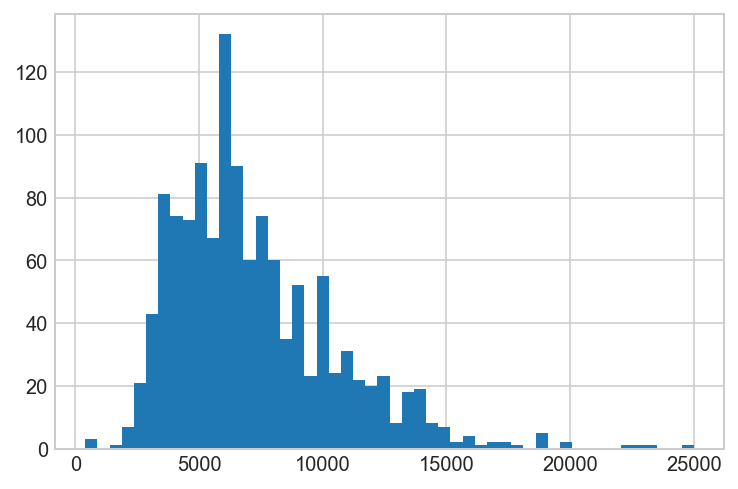

In [11]:
print(df['Salary_avg'].describe())
df['Salary_avg'].hist(bins=50)

In [12]:
df[df['Salary_avg']>df['Salary_avg'].quantile(q=0.75)].sort_values('Salary_avg', ascending=False)
#looks more in line with actual salary range

Company  \
262                                 DATASPARK PTE. LTD.   
475                                 Company Undisclosed   
278       AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED   
95                                        DBS BANK LTD.   
123                                    ORBIUM PTE. LTD.   
598                                 Company Undisclosed   
653                        NOVARTIS (SINGAPORE) PTE LTD   
154                                       CITIBANK N.A.   
188                                       CITIBANK N.A.   
609                                       CITIBANK N.A.   
729                       GOOGLE ASIA PACIFIC PTE. LTD.   
1384                      GOOGLE ASIA PACIFIC PTE. LTD.   
1249      AMAZON WEB SERVICES SINGAPORE PRIVATE LIMITED   
67                            INTELLECT MINDS PTE. LTD.   
517                           CREDIT SUISSE SERVICES AG   
785                                 Company Undisclosed   
1378                             RAKUTEN ASIA PTE. LTD.   
217                        INFOSYS CONSULTING PTE. LTD.   
687                           MARALL SERVICES PTE. LTD.   
823                  ROBERT WALTERS (SINGAPORE) PTE LTD   
41                        UNILEVER ASIA PRIVATE LIMITED   
850                               ASUS GLOBAL PTE. LTD.   
223                    SHOPEE SINGAPORE PRIVATE LIMITED   
562                           MARALL SERVICES PTE. LTD.   
203   MILLENNIUM CAPITAL MANAGEMENT (SINGAPORE) PTE....   
745                         GRABTAXI HOLDINGS PTE. LTD.   
286                       GOOGLE ASIA PACIFIC PTE. LTD.   
526                                  SAP ASIA PTE. LTD.   
757                       GOOGLE ASIA PACIFIC PTE. LTD.   
775                       GOOGLE ASIA PACIFIC PTE. LTD.   
...                                                 ...   
869             SINGAPORE UNIVERSITY OF SOCIAL SCIENCES   
1582                         MAERSK SINGAPORE PTE. LTD.   
1234                          BIGO TECHNOLOGY PTE. LTD.   
1329                                MEDIACORP PTE. LTD.   
1308                        KEYTEO CONSULTING PTE. LTD.   
1211                  DAIMLER SOUTH EAST ASIA PTE. LTD.   
813         OVERSEA-CHINESE BANKING CORPORATION LIMITED   
485                        INFORMATICA S.E.A. PTE. LTD.   
1408                                      ADDSTONES SAS   
767               MOODY'S ANALYTICS SINGAPORE PTE. LTD.   
1236                                Company Undisclosed   
696   LENOVO ENTERPRISE SOLUTIONS (SINGAPORE) PTE. LTD.   
1351                           COMTEL SOLUTIONS PTE LTD   
285                                 Company Undisclosed   
149                             STANDARD CHARTERED BANK   
951                             STANDARD CHARTERED BANK   
185                                 Company Undisclosed   
514                             NUTONOMY ASIA PTE. LTD.   
1372                          INTELLECT MINDS PTE. LTD.   
275                           INTELLECT MINDS PTE. LTD.   
126                         TANGSPAC CONSULTING PTE LTD   
204                          KERRY CONSULTING PTE. LTD.   
975                                    ICON OUTSOURCING   
1497                                      CITIBANK N.A.   
1494                      CAPGEMINI SINGAPORE PTE. LTD.   
1617                                      CITIBANK N.A.   
583      ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD.   
11             ESSENCE GLOBAL MEDIA SINGAPORE PTE. LTD.   
266                                       DBS BANK LTD.   
61                                        DBS BANK LTD.   

                                                  Title  \
262                              Director, Data Science   
475                 Senior Manager, Insights & Planning   
278          Sr. Data Architect, Data Warehousing & MPP   
95    Contract Staff (Snr), Program Director, CBG & ...   
123                                      Senior Manager   
598                                

In [13]:
#log salary due to log distribution
df['lg_sal_avg'] = np.log(df['Salary_avg'])
df['lg_sal_lower'] = np.log(df['Salary_lower'])
df['lg_sal_upper'] = np.log(df['Salary_upper'])

In [14]:
df.head()

Company  \
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   
6                          JPMORGAN CHASE BANK, N.A.   

                                              Title  \
1                                  Business Analyst   
2                                 Software Engineer   
3                           Data Analytics –Manager   
4                                   Research Fellow   
6  Application Support Analyst, Reference Data Team   

                                        Address  \
1                          1 DEPOT CLOSE 109841   
2          GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3  MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                           NaN   
6                                           NaN   

                         Emp_type                Seniority  \
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   
6                       Full Time                Executive   

                 Industry           Salary  \
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   
6  Information Technology  $6,000to$12,000   

                                      Responsibility  \
1  Roles & ResponsibilitiesHP is the world’s lead...   
2  Roles & ResponsibilitiesResponsibilities:   De...   
3  Roles & Responsibilities Advisory - Consulting...   
4  Roles & ResponsibilitiesData Scientist / Progr...   
6  Roles & ResponsibilitiesWe are seeking an Appl...   

                                        Requirements  Salary_lower  \
1  RequirementsEducation and Experience Required:...        8400.0   
2  RequirementsRequirements:   Minimum B.S. degre...        4400.0   
3  Requirements  A good Degree in a quantitative ...        6200.0   
4  Requirements Doctorate degree in a relevant fi...        4000.0   
6  RequirementsQualifications  7-10 years Product...        6000.0   

   Salary_upper  Salary_avg  Salary_avg_cat  lg_sal_avg  lg_sal_lower  \
1       12900.0     10650.0               2    9.273315      9.035987   
2        8000.0      6200.0               1    8.732305      8.389360   
3        9500.0      7850.0               1    8.968269      8.732305   
4        5000.0      4500.0               0    8.411833      8.294050   
6       12000.0      9000.0               1    9.104980      8.699515   

   lg_sal_upper  
1      9.464983  
2      8.987197  
3      9.159047  
4      8.517193  
6      9.392662

In [15]:
df['Seniority'] = df.Seniority.fillna('Others') #seniority with null values are tech and info comm lecturers
df.Seniority.value_counts()
#some job listed for multiple positions. to be cleaned
#Professional, Non-executive, Fresh/entry level, Junior Executive, Executive, Senior Executive, Manager

Professional                                                               266
Executive                                                                  245
Manager                                                                    178
Senior Executive                                                           136
Middle Management                                                           72
Senior Management                                                           45
Non-executive                                                               45
Fresh/entry level                                                           35
Junior Executive                                                            35
Professional, Executive                                                     33
Professional, Senior Executive                                              19
Executive, Senior Executive                                                 17
Manager, Senior Executive                           

In [16]:
#find rows with more than 1 seniority
df.Seniority = df.Seniority.astype('str')
df['snr_range'] = df.Seniority.map(lambda x: x.count(',')+1)

In [17]:
#find rank of seniority according to median salary
snr_rank = df[df['snr_range']==1].groupby('Seniority').median()['Salary_avg'].sort_values()
snr_dict = {}
for ind, snr in enumerate(snr_rank.index):
    snr_dict[snr] = ind
snr_dict

{'Executive': 3,
 'Fresh/entry level': 1,
 'Junior Executive': 0,
 'Manager': 8,
 'Middle Management': 7,
 'Non-executive': 4,
 'Others': 2,
 'Professional': 6,
 'Senior Executive': 5,
 'Senior Management': 9}

In [18]:
#allocate rank to rows with multiple seniority and get avg rank
df['snr_rank'] = df['Seniority'].apply(lambda x: x.split(', '))
df['snr_rank'] = [[snr_dict[i] for i in snr] for snr in df.snr_rank] 
df['snr_avg_rank'] = [round(sum(snr)/len(snr)) for snr in df.snr_rank]
print df['snr_avg_rank'].value_counts()
df.head()

6.0    295
3.0    253
8.0    186
5.0    161
4.0    104
7.0     98
9.0     45
0.0     40
1.0     39
2.0     24
Name: snr_avg_rank, dtype: int64


Company  \
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   
6                          JPMORGAN CHASE BANK, N.A.   

                                              Title  \
1                                  Business Analyst   
2                                 Software Engineer   
3                           Data Analytics –Manager   
4                                   Research Fellow   
6  Application Support Analyst, Reference Data Team   

                                        Address  \
1                          1 DEPOT CLOSE 109841   
2          GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3  MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                           NaN   
6                                           NaN   

                         Emp_type                Seniority  \
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   
6                       Full Time                Executive   

                 Industry           Salary  \
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   
6  Information Technology  $6,000to$12,000   

                                      Responsibility  \
1  Roles & ResponsibilitiesHP is the world’s lead...   
2  Roles & ResponsibilitiesResponsibilities:   De...   
3  Roles & Responsibilities Advisory - Consulting...   
4  Roles & ResponsibilitiesData Scientist / Progr...   
6  Roles & ResponsibilitiesWe are seeking an Appl...   

                                        Requirements  Salary_lower  \
1  RequirementsEducation and Experience Required:...        8400.0   
2  RequirementsRequirements:   Minimum B.S. degre...        4400.0   
3  Requirements  A good Degree in a quantitative ...        6200.0   
4  Requirements Doctorate degree in a relevant fi...        4000.0   
6  RequirementsQualifications  7-10 years Product...        6000.0   

   Salary_upper  Salary_avg  Salary_avg_cat  lg_sal_avg  lg_sal_lower  \
1       12900.0     10650.0               2    9.273315      9.035987   
2        8000.0      6200.0               1    8.732305      8.389360   
3        9500.0      7850.0               1    8.968269      8.732305   
4        5000.0      4500.0               0    8.411833      8.294050   
6       12000.0      9000.0               1    9.104980      8.699515   

   lg_sal_upper  snr_range snr_rank  snr_avg_rank  
1      9.464983          1      [6]           6.0  
2      8.987197          1      [3]           3.0  
3      9.159047          1      [8]           8.0  
4      8.517193          2   [6, 3]           4.0  
6      9.392662          1      [3]           3.0

In [19]:
# emp_type has multiple types as well
print df['Emp_type'].value_counts()
# drop internship to prevent skewing of salary
df = df[~df['Emp_type'].isin(['Internship','Part Time, Full Time, Internship','Part Time, Permanent, Internship'])]

Full Time                                                427
Permanent                                                275
Permanent, Full Time                                     232
Contract                                                 139
Contract, Full Time                                      126
Permanent, Contract, Full Time                            15
Permanent, Contract                                       10
Part Time, Full Time, Internship                           5
Part Time                                                  4
Internship                                                 3
Temporary, Contract                                        2
Contract, Freelance, Full Time, Flexi work                 1
Temporary, Contract, Full Time                             1
Part Time, Contract                                        1
Temporary                                                  1
Part Time, Temporary, Contract, Full Time, Flexi work      1
Part Time, Permanent, In

In [20]:
#create dictionary: full emp :2, partial emp:1, internship:0
emp_dict = {}
emp_dict['Permanent'] = 2
emp_dict['Full Time'] = 2
emp_dict['Contract'] = 1
emp_dict['Part Time'] = 1
emp_dict['Flexi work'] = 1
emp_dict['Temporary'] = 1
emp_dict['Freelance'] = 1

In [21]:
#find rows with more than 1 emp_type
df.Emp_type = df.Emp_type.astype('str')
df['emp_range'] = df.Emp_type.map(lambda x: x.count(',')+1)

In [22]:
#allocate rank to rows with multiple emp type and get avg rank
#ideally there should be 3 ranks - 1: partial emp, 1.5: partial/full empp, 2: full emp
df['emp_rank'] = df['Emp_type'].apply(lambda x: x.split(', '))
df['emp_rank'] = [[emp_dict[i] for i in emp] for emp in df.emp_rank] 
df['emp_avg_rank'] = [(max(emp)+float(min(emp)))/2 for emp in df.emp_rank] #rank 1.5 if job is seeking for both full/partial emp
# df['emp_min_rank'] = [min(emp) for emp in df.emp_rank]
# df['emp_max_rank'] = [max(emp) for emp in df.emp_rank]
# df['emp_avg_rank'] =[round(sum(emp)/float(len(emp)),1) for emp in df.emp_rank]
print df['emp_avg_rank'].value_counts()
df.head()

2.0    934
1.5    154
1.0    148
Name: emp_avg_rank, dtype: int64


Company  \
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   
6                          JPMORGAN CHASE BANK, N.A.   

                                              Title  \
1                                  Business Analyst   
2                                 Software Engineer   
3                           Data Analytics –Manager   
4                                   Research Fellow   
6  Application Support Analyst, Reference Data Team   

                                        Address  \
1                          1 DEPOT CLOSE 109841   
2          GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3  MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                           NaN   
6                                           NaN   

                         Emp_type                Seniority  \
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   
6                       Full Time                Executive   

                 Industry           Salary  \
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   
6  Information Technology  $6,000to$12,000   

                                      Responsibility  \
1  Roles & ResponsibilitiesHP is the world’s lead...   
2  Roles & ResponsibilitiesResponsibilities:   De...   
3  Roles & Responsibilities Advisory - Consulting...   
4  Roles & ResponsibilitiesData Scientist / Progr...   
6  Roles & ResponsibilitiesWe are seeking an Appl...   

                                        Requirements  Salary_lower  \
1  RequirementsEducation and Experience Required:...        8400.0   
2  RequirementsRequirements:   Minimum B.S. degre...        4400.0   
3  Requirements  A good Degree in a quantitative ...        6200.0   
4  Requirements Doctorate degree in a relevant fi...        4000.0   
6  RequirementsQualifications  7-10 years Product...        6000.0   

       ...       Salary_avg_cat  lg_sal_avg  lg_sal_lower  lg_sal_upper  \
1      ...                    2    9.273315      9.035987      9.464983   
2      ...                    1    8.732305      8.389360      8.987197   
3      ...                    1    8.968269      8.732305      9.159047   
4      ...                    0    8.411833      8.294050      8.517193   
6      ...                    1    9.104980      8.699515      9.392662   

   snr_range  snr_rank  snr_avg_rank emp_range   emp_rank  emp_avg_rank  
1          1       [6]           6.0         2     [2, 2]           2.0  
2          1       [3]           3.0         2     [2, 2]           2.0  
3          1       [8]           8.0         3  [2, 1, 2]           1.5  
4          2    [6, 3]           4.0         2     [1, 2]           1.5  
6          1       [3]           3.0         1        [2]           2.0  

[5 rows x 22 columns]

In [23]:
#get first two digits of address zip codes which represent postal districts (https://en.wikipedia.org/wiki/Postal_codes_in_Singapore)
df['districts'] = df['Address'].str[-6:-4]
df['districts'] = pd.to_numeric(df['districts'], errors='coerce')

In [24]:
df['districts'] = df['districts'].fillna('Others')

In [25]:
#remove Roles & Responsibilities from start of sentence
df['Responsibility'] = df['Responsibility'].str[24:]
#remove Requirements from start of sentence
df['Requirements'] = df['Requirements'].str[12:]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 1 to 1625
Data columns (total 23 columns):
Company           1236 non-null object
Title             1236 non-null object
Address           930 non-null object
Emp_type          1236 non-null object
Seniority         1236 non-null object
Industry          1236 non-null object
Salary            1236 non-null object
Responsibility    1236 non-null object
Requirements      1217 non-null object
Salary_lower      1236 non-null float64
Salary_upper      1236 non-null float64
Salary_avg        1236 non-null float64
Salary_avg_cat    1236 non-null int64
lg_sal_avg        1236 non-null float64
lg_sal_lower      1236 non-null float64
lg_sal_upper      1236 non-null float64
snr_range         1236 non-null int64
snr_rank          1236 non-null object
snr_avg_rank      1236 non-null float64
emp_range         1236 non-null int64
emp_rank          1236 non-null object
emp_avg_rank      1236 non-null float64
districts         1236 non-null

In [27]:
df['Industry'].value_counts()
#multiple industries tagged to a job. have to dummy the multi_labels

Information Technology                                                                                     419
Banking and Finance                                                                                        167
Sciences / Laboratory / R&D                                                                                 63
Engineering                                                                                                 62
Others                                                                                                      55
Marketing / Public Relations                                                                                53
Consulting                                                                                                  51
Advertising / Media                                                                                         38
Banking and Finance, Information Technology                                                                 29
H

In [28]:
#multi_label dummies for industries - drop baseline IT later
ind_dum = df['Industry'].str.get_dummies(sep=', ')
print 'No. of Industries:', len(ind_dum.columns)
# ind_dum['ind_range'] = ind_dum.sum(axis=1)
df = pd.concat([df, ind_dum], axis=1)
df['ind_range'] = ind_dum.sum(axis=1)
print 'Jobs tagged with multi industries:', len(df[df['ind_range']>1])
print 'Max industries tagged to a job:', df['ind_range'].max()
df.loc[:,:'ind_range'].head()

No. of Industries: 35
Jobs tagged with multi industries: 202
Max industries tagged to a job: 5


Company  \
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   
6                          JPMORGAN CHASE BANK, N.A.   

                                              Title  \
1                                  Business Analyst   
2                                 Software Engineer   
3                           Data Analytics –Manager   
4                                   Research Fellow   
6  Application Support Analyst, Reference Data Team   

                                        Address  \
1                          1 DEPOT CLOSE 109841   
2          GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3  MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                           NaN   
6                                           NaN   

                         Emp_type                Seniority  \
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   
6                       Full Time                Executive   

                 Industry           Salary  \
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   
6  Information Technology  $6,000to$12,000   

                                      Responsibility  \
1  HP is the world’s leading personal systems and...   
2  Responsibilities:   Develop and enhance data i...   
3   Advisory - Consulting  PwC Consulting is a re...   
4  Data Scientist / Programmer for Regional ATM M...   
6  We are seeking an Application Support Analyst ...   

                                        Requirements  Salary_lower    ...      \
1  Education and Experience Required:   Prior exp...        8400.0    ...       
2  Requirements:   Minimum B.S. degree in Compute...        4400.0    ...       
3    A good Degree in a quantitative discipline (...        6200.0    ...       
4   Doctorate degree in a relevant field. At leas...        4000.0    ...       
6  Qualifications  7-10 years Production support ...        6000.0    ...       

   Public / Civil Service  Purchasing / Merchandising  \
1                       0                           0   
2                       0                           0   
3                       0                           0   
4                       0                           0   
6                       0                           0   

   Real Estate / Property Management  Risk Management  Sales / Retail   \
1                                  0                0                0   
2                                  0                0                0   
3                                  0                0                0   
4                                  0                0                0   
6                                  0                0                0   

   Sciences / Laboratory / R&D  Security and Investigation Telecommunications  \
1                            0                           0                  0   
2                            0                           0                  0   
3                            0                           0                  0   
4                            0                           0                  0   
6                            0                           0                  0   

   Travel / Tourism  ind_range  
1                 0          1  
2                 0          1  
3                 0          1  
4                 0          1  
6                 0          1  

[5 rows x 59 columns]

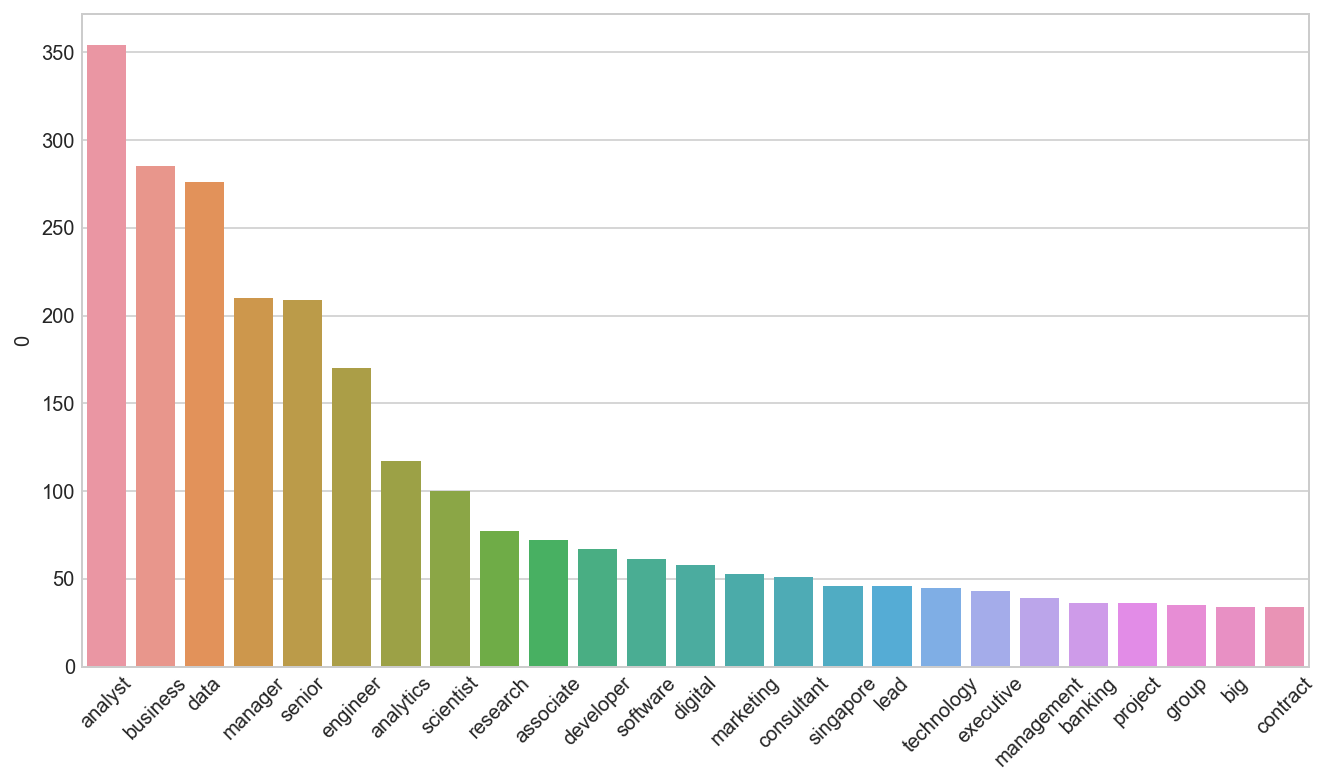

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvt      =  CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1), min_df=2)
X = pd.DataFrame(cvt.fit_transform(df['Title']).todense(),
             columns=cvt.get_feature_names())#binary=True if BernoulliNB version of Naive Bayes is used
#print top words
plot = X.sum(axis=0).sort_values(ascending = False).head(25)
plot = pd.DataFrame(plot)
fig, ax = plt.subplots(figsize=(11,6))
g = sns.barplot(plot.index, plot[0])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show();

In [30]:
df['Title'] = df['Title'].map(lambda x: x.lower())
#getting meaningful data broader job categories analyst, engineer, analytics, research, developer, software, digital, consultant, 
df['cat_Analyst'] = df['Title'].str.contains('analyst')*1
df['cat_Engineer'] = df['Title'].str.contains('engineer')*1
df['cat_Analytics'] = df['Title'].str.contains('analytics')*1
df['cat_Scientist'] = df['Title'].str.contains('scientist|science')*1
df['cat_Research'] = df['Title'].str.contains('research')*1
df['cat_Developer'] = df['Title'].str.contains('developer')*1
df['cat_Software'] = df['Title'].str.contains('software')*1
df['cat_Digital'] = df['Title'].str.contains('digital')*1
df['cat_Consultant'] = df['Title'].str.contains('consultant|consulting')*1
df['cat_Intelligence'] = df['Title'].str.contains('intelligence|consumer')*1
df['cat_Marketing'] = df['Title'].str.contains('marketing|market|consumer')*1
df['cat_Bigdata'] = df['Title'].str.contains('big data')*1
df['cat_Project'] = df['Title'].str.contains('project')*1
df['cat_Sales'] = df['Title'].str.contains('sales')*1
df['cat_HR'] = df['Title'].str.contains('hr|human resource')*1

In [31]:
print df['cat_Analyst'].sum()
print df['cat_Engineer'].sum()
print df['cat_Analytics'].sum()
print df['cat_Scientist'].sum()
print df['cat_Research'].sum()
print df['cat_Developer'].sum()
print df['cat_Software'].sum()
print df['cat_Digital'].sum()
print df['cat_Consultant'].sum()
print df['cat_Intelligence'].sum()
print df['cat_Marketing'].sum()
print df['cat_Bigdata'].sum()
print df['cat_Project'].sum()
print df['cat_Sales'].sum()
print df['cat_HR'].sum()

354
169
118
114
70
65
61
58
64
55
97
34
39
17
27


In [32]:
df['cat_Others'] = (df.loc[:,'cat_Analyst':'cat_HR'].sum(axis=1) == 0)*1
print 'length of unlabeled job cat:', df['cat_Others'].sum(),'or',round(df['cat_Others'].sum()/float(len(df))*100,2),'% of data'
cat_cols = df.loc[:,'cat_Analyst':'cat_Others'].columns

length of unlabeled job cat: 253 or 20.47 % of data


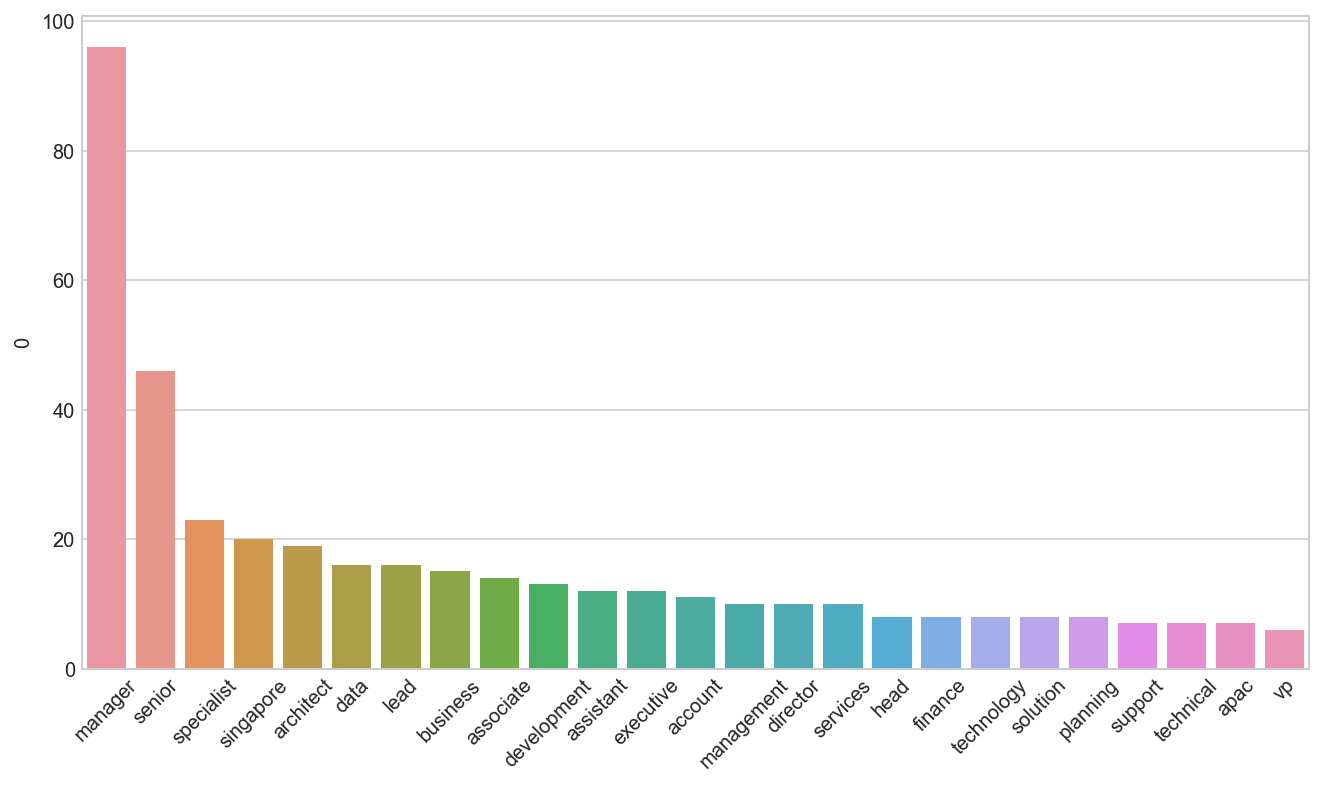

In [33]:
#remaining words for job titles
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
#print top words
plot = X.sum(axis=0).sort_values(ascending = False).head(25)
plot = pd.DataFrame(plot)
fig, ax = plt.subplots(figsize=(11,6))
g = sns.barplot(plot.index, plot[0])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show();

In [34]:
df[df['cat_Others'] == 1]['Title'].values

array(['associate, compliance, conflicts of interest & conduct monitoring',
       'associate director', 'copywriter', 'cloud solution architect',
       'web designer',
       'finance manager, procurement (cash value partnering)',
       'martech executive', 'senior executive, data services',
       'director of technology', 'business transformation partner',
       'pricing specialist',
       'healthcare associate, innovation & data insights',
       'head of demand, mopub apac (singapore)',
       'business integrity associate',
       'senior associates, people advisory services, advisory, singapore',
       'vp - hadoop support lead', 'business development manager',
       'senior manager', 'architect', 'recruiter (gtech) - singapore',
       'senior manager, indirect tax , aptc, singapore',
       'actuarial executive', 'operations manager',
       'corporate brand and communication manager',
       'avp  /  snr assoc, ibgt platform support \xe2\x80\x93 acct mgmt reporting, ibg

## 1.2: Check (non-text heavy) engineered features relationship with avg salary

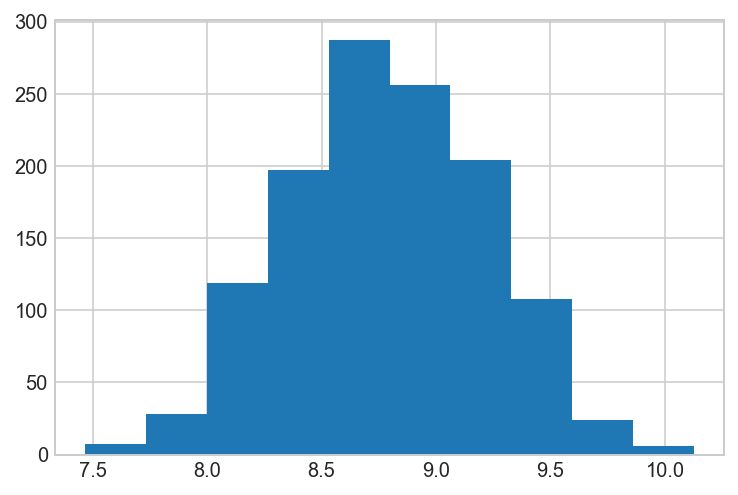

In [35]:
df['lg_sal_avg'].hist()

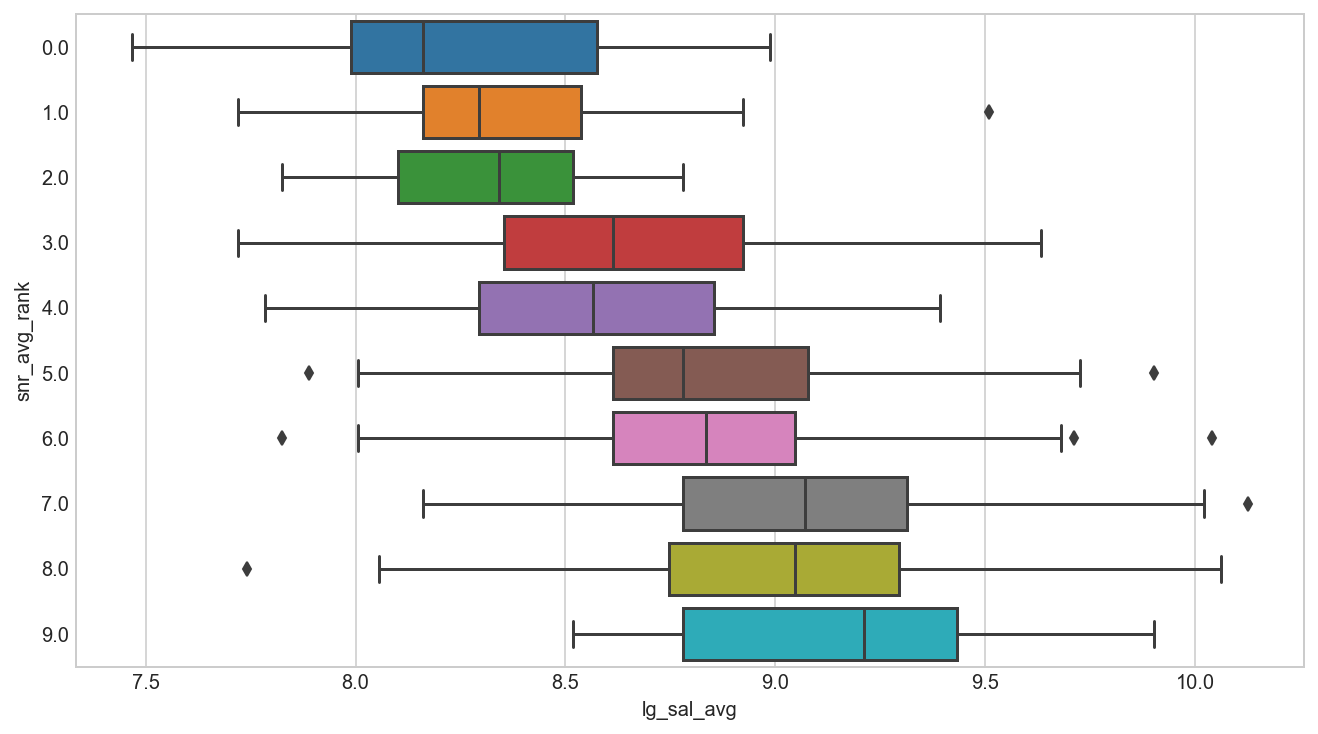

In [36]:
#double 
#seniority ranks
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lg_sal_avg', y='snr_avg_rank', data=df, orient='h', ax=ax)

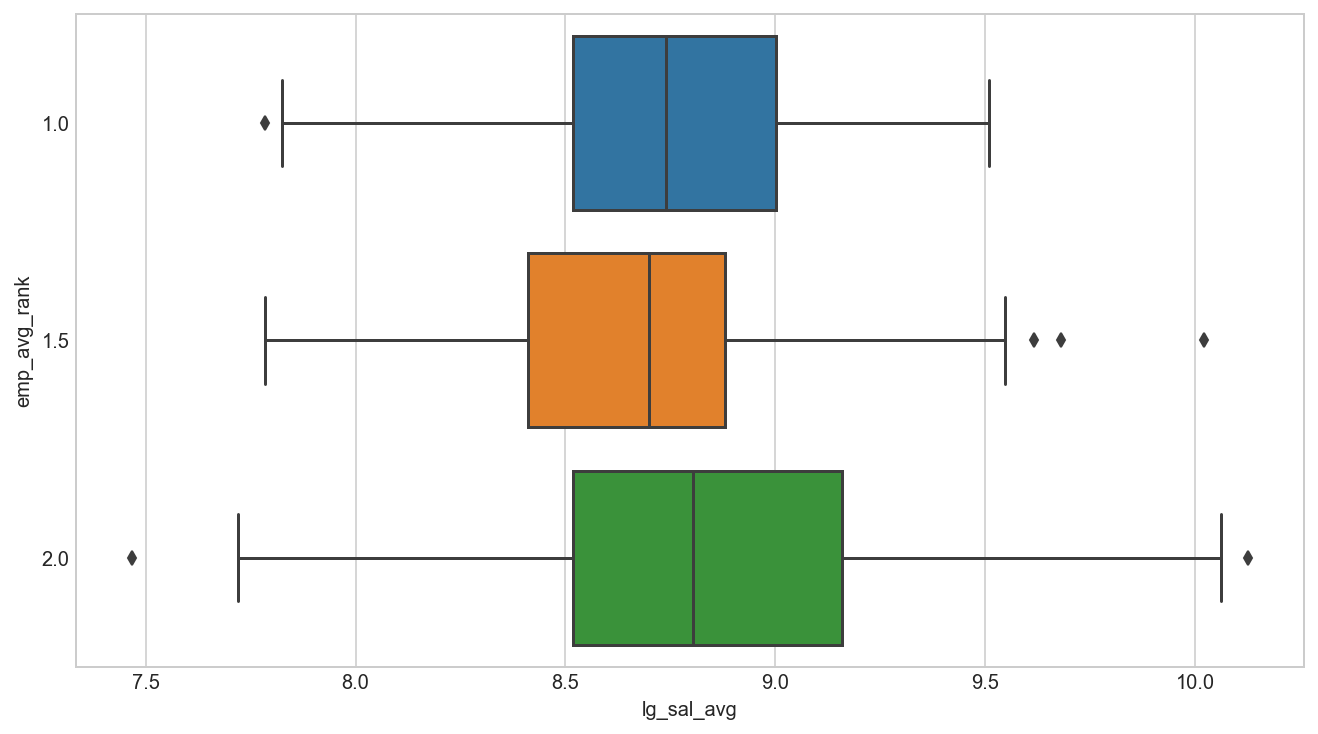

In [37]:
#double check engineered features relationship with lg_avg_salary
#seniority ranks
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lg_sal_avg', y='emp_avg_rank', data=df, orient='h', ax=ax)

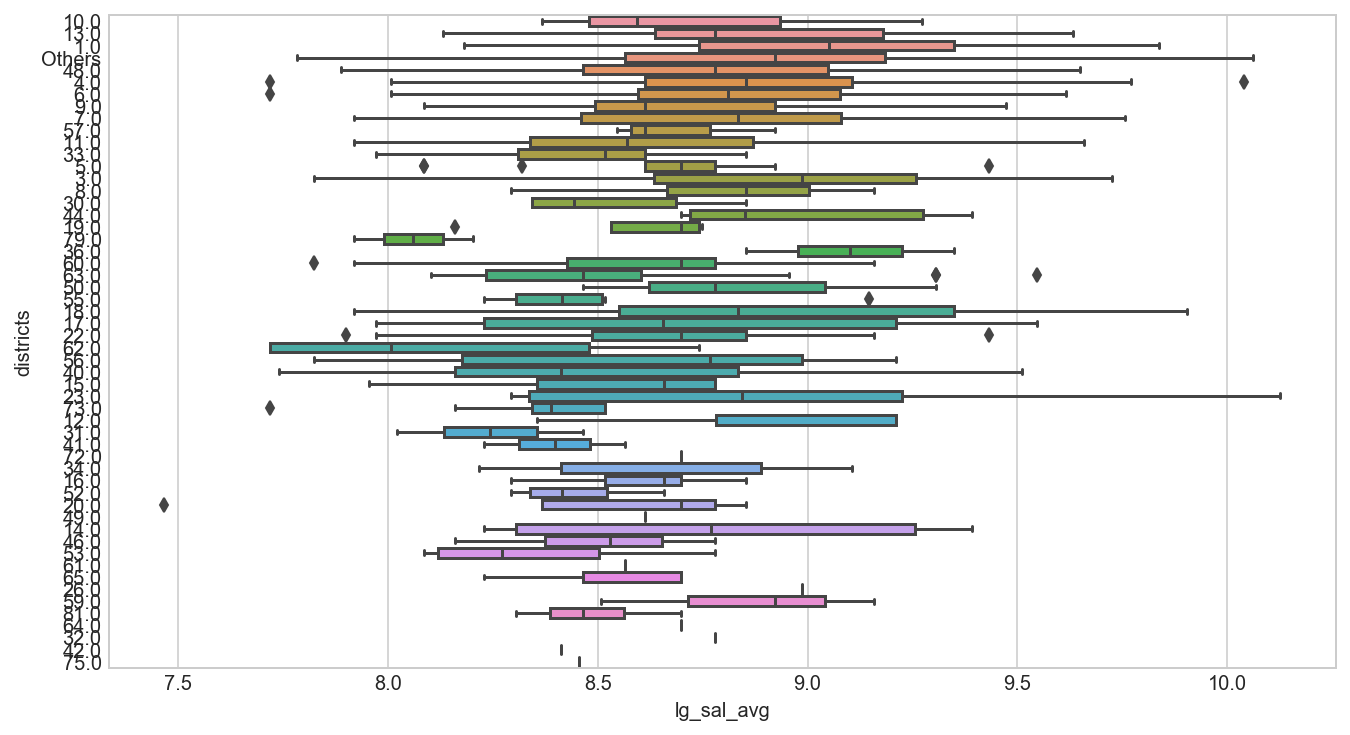

In [38]:
#double check engineered features relationship with lg_avg_salary
#districts ranks
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lg_sal_avg', y='districts', data=df, orient='h', ax=ax)
#seems like there are too many districts cateogry with few datapoints

In [39]:
#subsum districts with limited datapoints into others
otherls = []
for dis, ct in df['districts'].value_counts().items():
    if ct<30:
        otherls.append(dis)
df.loc[df['districts'].isin(otherls), 'districts'] = 'Others'

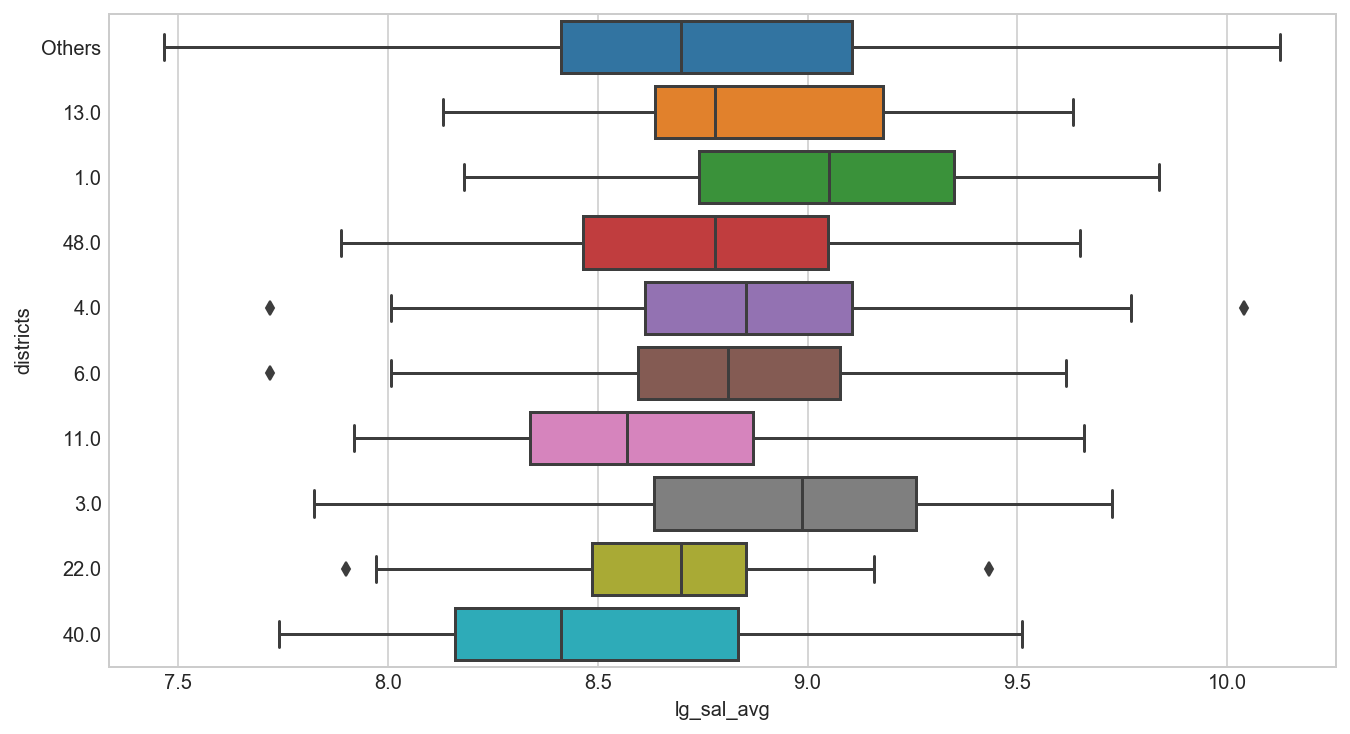

In [40]:
#districts ranks
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lg_sal_avg', y='districts', data=df, orient='h', ax=ax)

In [41]:
#plot top industries only
ind_ct = {}
for ind in ind_dum.columns:
    ind_ct[ind] = df[ind].sum()
top_ind = pd.DataFrame(sorted(ind_ct.items(), key=lambda x: x[1], reverse=True)[:10])
top_ind

0    1
0            Information Technology  516
1               Banking and Finance  227
2                       Engineering  103
3                       Consulting    85
4                            Others   84
5     Marketing / Public Relations    78
6       Sciences / Laboratory / R&D   76
7              Advertising / Media    55
8            Education and Training   34
9  Accounting / Auditing / Taxation   31

Text(0.5,0,u'')

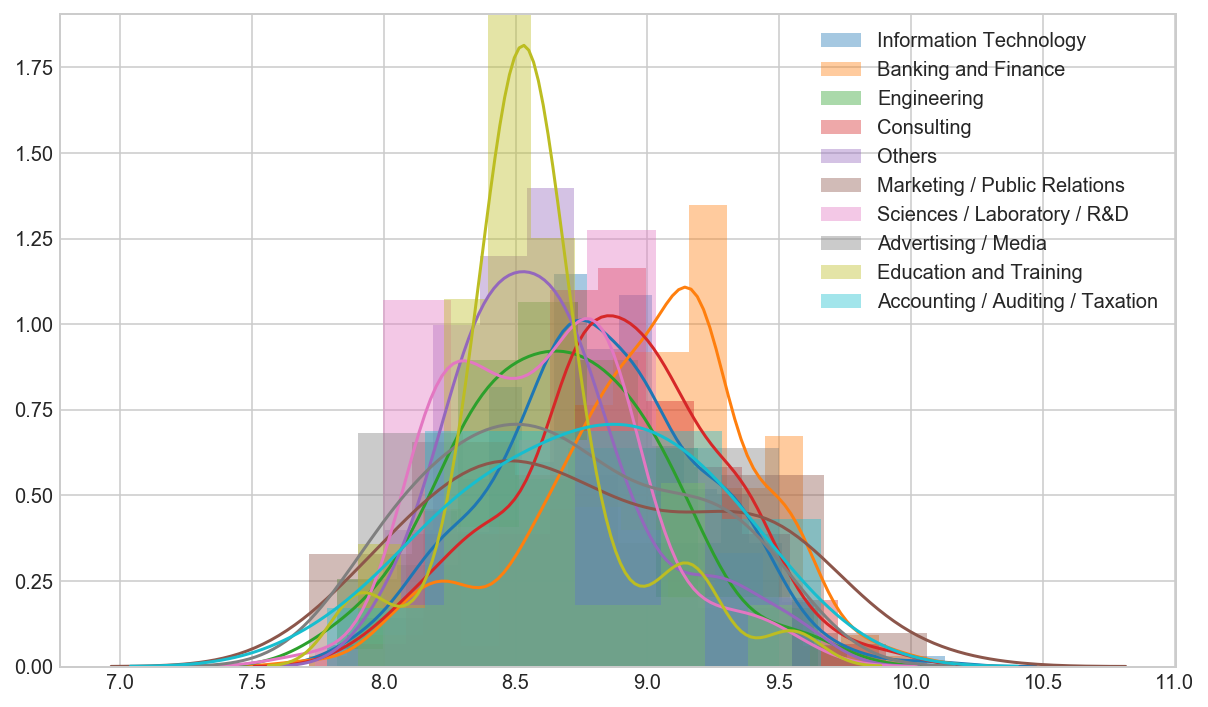

In [42]:
#set figure size for plot
plt.figure(figsize=(10,6))
#plot distribution for each variable
for ind in top_ind[0]:
    sns.distplot(df[df[ind]==1]['lg_sal_avg'], label=ind)
plt.legend()
plt.legend(prop={'size': 10})
plt.xlabel('', fontsize=2) 
#some differences in salary distribution across industries bank avg salary: exp(9) = 8103; engineering avg salary: exp(8.8) = 4915

In [43]:
#plot top industries only
cat_ct = {}
for col in cat_cols:
    cat_ct[col] = df[col].sum()
top_cat = pd.DataFrame(sorted(cat_ct.items(), key=lambda x: x[1], reverse=True)[:10])
top_cat

0    1
0     cat_Analyst  354
1      cat_Others  253
2    cat_Engineer  169
3   cat_Analytics  118
4   cat_Scientist  114
5   cat_Marketing   97
6    cat_Research   70
7   cat_Developer   65
8  cat_Consultant   64
9    cat_Software   61

Text(0.5,0,u'')

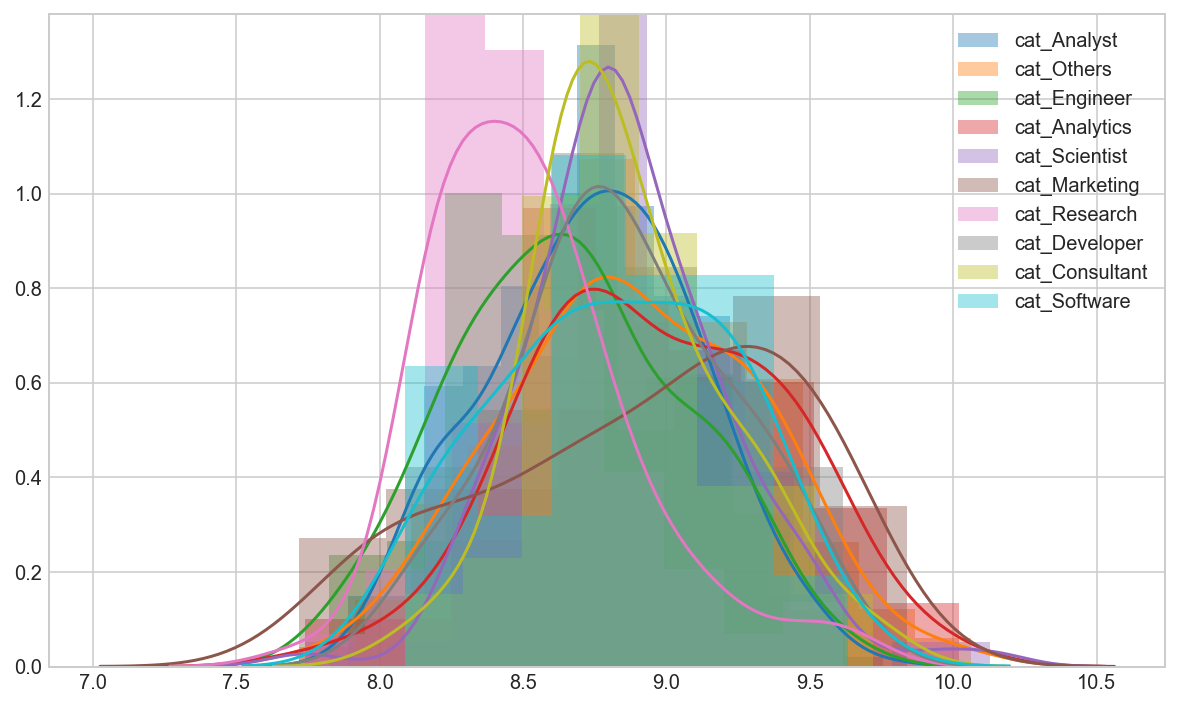

In [44]:
#set figure size for plot
plt.figure(figsize=(10,6))
#plot distribution for each variable
for col in top_cat[0]:
    sns.distplot(df[df[col]==1]['lg_sal_avg'], label=col)
plt.legend()
plt.legend(prop={'size': 10})
plt.xlabel('', fontsize=2)
#some differences in salary distribution across job categories, researchers having the lower income while marketers have higher value

### Trying out a model performance without text information first

In [45]:
#create dummies
df['snr_avg_rank'] = df['snr_avg_rank'].astype('O')
df['emp_avg_rank'] = df['emp_avg_rank'].astype('O')
dummies = pd.get_dummies(df[['snr_avg_rank','emp_avg_rank','districts']], drop_first = True)

In [46]:
df[cat_cols].tail()

cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist  cat_Research  \
1620            0             1              0              0             0   
1621            0             1              0              0             0   
1623            1             0              0              0             0   
1624            0             0              0              0             0   
1625            1             0              0              0             0   

      cat_Developer  cat_Software  cat_Digital  cat_Consultant  \
1620              0             0            0               0   
1621              0             1            0               0   
1623              0             0            0               0   
1624              0             0            1               0   
1625              0             0            0               0   

      cat_Intelligence  cat_Marketing  cat_Bigdata  cat_Project  cat_Sales  \
1620                 0              0            0            0          0   
1621                 0              0            0            0          0   
1623                 0              0            0            0          1   
1624                 0              0            0            0          0   
1625                 0              0            0            0          0   

      cat_HR  cat_Others  
1620       0           0  
1621       0           0  
1623       0           0  
1624       0           0  
1625       0           0

In [47]:
#getting the dataset
df_ind_w_ranks = ind_dum.merge(dummies, left_index = True, right_index = True,how = 'outer')#merge back
df_sel = df[cat_cols].merge(df_ind_w_ranks, left_index = True, right_index = True,how = 'outer')#merge back
y = df['lg_sal_avg']
#train-test split
from sklearn.model_selection import train_test_split
df_sel_train, df_sel_test, y_train, y_test = train_test_split(df_sel, y, test_size=0.2, random_state=42) #can add in stratify=y

In [48]:
#feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression
selector=SelectKBest(score_func=f_regression,k=20) #k select 5 predictors from f-test
selector.fit(df_sel_train,y_train)
list(zip(df_sel_train.columns.values, selector.scores_, selector.pvalues_)) #print variable, F-test value & p-value
X_f_col = np.array(df_sel_train.columns[selector.get_support(True)]) #select chosen column, true gives column index
print 'f_features:'
print X_f_col,'\n'

#Recursive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(df_sel_train, y_train)
list(zip(df_sel_train.columns.values, selector.support_, selector.ranking_)) #print variables, selection and ranks -> rank 1 is the best
X_RFECV_col = np.array(df_sel_train.columns[selector.support_]) #select chosen column from TRUE
print 'recursive_features:'
print X_RFECV_col,'\n'

#lasso feature selection
#lasso requires standardization first
from sklearn.preprocessing import StandardScaler
X_train_ss = StandardScaler().fit_transform(df_sel_train)
X_train_ss
from sklearn.linear_model import LogisticRegressionCV, LassoCV
#lasso with cross-validation
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV decide what alphas to use, just set no. of alphas to test.
optimal_lasso.fit(X_train_ss, y_train)
coefs = list(zip(df_sel_train.columns.values, optimal_lasso.coef_))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
X_lasso_col = coefs[coefs['abs'] != 0].sort_values('abs', ascending=False)
X_lasso_col = np.array(X_lasso_col.iloc[:,0])
print 'X_lasso_col:'
print X_lasso_col

f_features:
['cat_Engineer' 'cat_Analytics' 'cat_Research' 'cat_Bigdata' 'cat_HR'
 'cat_Others' 'Admin / Secretarial' 'Banking and Finance' 'Others'
 'Sciences / Laboratory / R&D' 'snr_avg_rank_1.0' 'snr_avg_rank_2.0'
 'snr_avg_rank_3.0' 'snr_avg_rank_4.0' 'snr_avg_rank_7.0'
 'snr_avg_rank_8.0' 'snr_avg_rank_9.0' 'emp_avg_rank_1.5'
 'emp_avg_rank_2.0' 'districts_Others'] 

recursive_features:
['cat_Scientist' 'cat_Research' 'cat_Developer' 'cat_Software'
 'cat_Bigdata' 'cat_Sales' 'Admin / Secretarial' 'Banking and Finance'
 'Building and Construction' 'Consulting ' 'Customer Service' 'Design'
 'Entertainment' 'F&B' 'General Management' 'Healthcare / Pharmaceutical'
 'Human Resources ' 'Information Technology' 'Medical / Therapy Services'
 'Purchasing / Merchandising' 'Real Estate / Property Management'
 'Risk Management' 'Security and Investigation' 'snr_avg_rank_1.0'
 'snr_avg_rank_2.0' 'snr_avg_rank_3.0' 'snr_avg_rank_4.0'
 'snr_avg_rank_5.0' 'snr_avg_rank_6.0' 'snr_avg_rank_7.0'
 '

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
# Defining a function to test our best features head to head.
lr = LinearRegression()

def score(X):
    scores = cross_val_score(lr, X, y_train, cv=5)
    return scores.mean(), scores.std()

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(df_sel_train[X_f_col]),
    score(df_sel_train[X_RFECV_col]),
    score(df_sel_train[X_lasso_col]),
    score(df_sel_train)]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])

mean score     std score
kbest  2.345365e-01  7.489185e-02
rfecv  3.522208e-01  4.617247e-02
lr     3.223619e-01  3.818028e-02
all   -4.949721e+24  9.422339e+24

### Looks like rfecv selected columns give the best results of 0.35.

## 2: Clean and engineer text columns

## Put job description and job requirements tgt for analysis
### Clean weird characters and lemmatize words to their roots

In [50]:
df["job_text"] = df["Responsibility"] + " " + df["Requirements"].fillna('NONE')#throws error if np.nan
# df["job_text"] = df["Requirements"].fillna('NONE')#throws error if np.nan

In [51]:
#remove punctuations and lower text
import string
# df["job_text"] = df["job_text"].map(lambda x: x.translate(None, string.punctuation).lower())
import re
df["job_text"] = df["job_text"].map(lambda x: re.sub('[^ a-zA-Z0-9]', ' ', x).lower()) #replace weird char with space + lower case
df["job_text"] = df["job_text"].map(lambda x: " ".join(x.split())) #remove additional spaces
df["job_text"].values

array(['hp is the world s leading personal systems and printing company we create technology that makes life better for everyone everywhere our innovation springs from a team of individuals each collaborating and contributing their own perspectives knowledge and experience to advance the way the world works and lives we are looking for visionaries like you who are ready to make a purposeful impact on the way the world works at hp the future is yours to create if you are our business analyst in singapore you will have a chance to provide analysis to support business team s needs by ensuring data integrity accuracy be the interface to sales operations be the interface to external analyst canalys idc establish enable quarterly published reports drive regular scheduled review of analysis with team cross team members update market share quarterly provide insights small and medium business smb segment with pc print support team during budgeting process key analytics includes volume value sma

In [52]:
y = df['lg_sal_avg']
X = df['job_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#lemmatize the text
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [54]:
 
X_train_lem = X_train_lem.apply(lambda x: " ".join(x))
X_train_lem.values

array([u'nutonomy aim to be the first company in the world to launch an autonomous taxi system and we are building up an awesome team to make this goal a reality we are developing the first of it kind complete solution for providing point to point mobility via large fleet of autonomous vehicle this includes software for autonomous vehicle smartphone based ride hailing fleet management and teleoperation the company s software ha been tested extensively on public road in the u s and singapore we offer a unique opportunity to work closely with expert from a wide array of background to create ground breaking technology with potential for huge impact a a member of a fast growing start up you will be able to make a large contribution to the final product for more information about nutonomy visit www nutonomy com we are seeking highly talented research engineer focused on computer vision machine learning to support a variety of team job description a robust and adaptive perception system is e

In [55]:
X_test_lem = X_test.apply(lemmatize_text)
X_test_lem = X_test_lem.apply(lambda x: " ".join(x) )
X_test_lem.values

array([u'description we re looking for the next generation of creative problem solver a a graduate engineer at dyson you ll be using your technical and creative skill from day one to help u develop revolutionary new technology dyson opened it new singapore technology centre earlier this year in this ambitious top secret centre some of the world s brightest engineering mind continually push the boundary of science technology available position are in the function of mechanical design fluid dynamic structural analysis and acoustic vibration market overview our singapore story began in 2004 and today we have more than 1000 people working here at the beginning of 2017 we opened our new state of the art singapore technology centre in science park i minute from singapore s technology and start up community this new technology centre house some of dyson s most advanced facility including robotics and sensor laboratory and smart home connectivity mobile application laboratory a well a an advan

## Run simple linear regression to find optimal word vect parameters:
### ngrams, max_features, max_df, tfidf

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

pipe = Pipeline([
    ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
    ('tfidf', TfidfTransformer()),
    ('reg', LinearRegression())

]) 
#cross validate
scores = cross_val_score(pipe, X_train_lem, y_train, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(0.39, 0.054)

In [57]:
#validate on test set to check for overfitting
model = pipe.fit(X_train_lem, y_train)
model.score(X_test_lem, y_test)
#test score is higher, no overfitting

0.4868336144308535

### Choose max_features=150,000, ngram(1,3), min_df=1
ngram(1,3), min_df=2 : (0.226, 0.151)

ngram(1,3), min_df=1 : (0.368, 0.043) 
with max_features=150000: (0.371, 0.044)

ngram(1,4), min_df=1 : (0.358, 0.043) 

## Explore boosting algorithms (randomforest, xgboost) + elasticnet:
### Too time consuming for full gridsearch, not able to improve score much with random searches.
### To consider PCA to transform/reduce features before trying boosting techniques later.

In [58]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# grid = {'reg__l1_ratio': [0.1,0.9]
# }

# pipe = Pipeline([
#     ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
#     ('tfidf', TfidfTransformer()),
#     ('reg', ElasticNetCV(n_alphas=30))
# #     ('logit', LogisticRegression())
# ]) 

In [59]:
# el_gs = GridSearchCV(pipe, grid, cv = 3, verbose=2)
# # Fit the random search model
# el_gs.fit(X_train_lem, y_train)
# print el_gs.best_score_ #0.3381787617169871
# print el_gs.best_params_ # {'reg__l1_ratio': 0.1}

In [60]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# random_grid = {'reg__bootstrap': [True],
#  'reg__max_depth': [100, None],
#  'reg__max_features': ['auto', 'sqrt'],
#  'reg__min_samples_leaf': [1, 2, 4],
#  'reg__min_samples_split': [2, 5, 10]
# }

# # 0.2748287022456429
# # {'reg__bootstrap': True, 'reg__min_samples_leaf': 3, 'reg__max_depth': None, 'reg__max_features': 'auto', 'reg__min_samples_split': 13}

# pipe = Pipeline([
#     ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
#     ('tfidf', TfidfTransformer()),
#     ('reg', RandomForestRegressor())
# #     ('logit', LogisticRegression())
# ]) 

In [61]:
# rf_gs = GridSearchCV(pipe, random_grid, cv = 3, verbose=2)
# # Fit the random search model
# rf_gs.fit(X_train_lem, y_train)
# print rf_random.best_score_ #0.2830788152776108
# print rf_random.best_params_ #{'reg__bootstrap': True, 'reg__min_samples_leaf': 4, 'reg__max_depth': None, 'reg__max_features': 'auto', 'reg__min_samples_split': 10}

0.2830788152776108
{'reg__bootstrap': True, 'reg__min_samples_leaf': 4, 'reg__max_depth': None, 'reg__max_features': 'auto', 'reg__min_samples_split': 10}
0.2748287022456429
{'reg__bootstrap': True, 'reg__min_samples_leaf': 3, 'reg__max_depth': None, 'reg__max_features': 'auto', 'reg__min_samples_split': 13}

## 3: Combine vectorize text and selected dummy cols into csr (to reduce memory and improve processing speed) before optimizing model

### For recap, following two data frames are going to be used.

In [62]:
X_train_lem.head()

1221    nutonomy aim to be the first company in the wo...
510     about the institute for infocomm research i r ...
1333    provide administrative support such a maintain...
1050    a world changing company at palantir we re pas...
114     responsibility gather analyze and document rep...
Name: job_text, dtype: object

In [63]:
df_sel_train.head()

cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist  cat_Research  \
1221            0             1              0              0             1   
510             0             1              0              0             1   
1333            1             0              0              0             0   
1050            1             0              0              0             0   
114             1             0              0              0             0   

      cat_Developer  cat_Software  cat_Digital  cat_Consultant  \
1221              0             0            0               0   
510               0             0            0               0   
1333              0             0            0               0   
1050              0             0            0               0   
114               1             0            0               0   

      cat_Intelligence        ...         emp_avg_rank_2.0  districts_3.0  \
1221                 0        ...                        1              0   
510                  0        ...                        0              0   
1333                 0        ...                        1              0   
1050                 0        ...                        1              0   
114                  1        ...                        1              0   

      districts_4.0  districts_6.0  districts_11.0  districts_13.0  \
1221              0              0               0               1   
510               1              0               0               0   
1333              0              0               0               0   
1050              0              0               0               0   
114               0              0               0               0   

      districts_22.0  districts_40.0  districts_48.0  districts_Others  
1221               0               0               0                 0  
510                0               0               0                 0  
1333               0               0               0                 0  
1050               0               0               0                 1  
114                0               0               0                 1  

[5 rows x 71 columns]

In [64]:
#previous selected dummy features score
lr = LinearRegression()
scores = cross_val_score(lr, df_sel_train[X_RFECV_col], y_train, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.352, 0.046)

In [65]:
#previous text features score
vect_text = Pipeline([
    ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
    ('tfidf', TfidfTransformer())
]) 
#cross validate
X_train_lem_df = vect_text.fit_transform(X_train_lem)
lr = LinearRegression()
scores = cross_val_score(lr, X_train_lem_df, y_train, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.365, 0.05)

### Hopefully combining the data features will improve CV scores beyond 0.352 and 0.365.
#### Text features score is lower than direct pipeline CV score, perhaps due to shuffling of CV data rows.

### Combine both dataframe using scipy sparse

In [66]:
import scipy as sp
# #pipeline
# vect_text = Pipeline([
#     ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
#     ('tfidf', TfidfTransformer())
# ]) 
# csr sparse matrix of non-text and text
# y_train_csr = y_train.values.astype(np.float32) 
# X_train_csr = sp.sparse.hstack((vect_text.fit_transform(X_train_lem),df_sel_train[X_RFECV_col].values),format='csr')

#cant use pipeline if we want the vectorized text col names
cvect = CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)
vect_text_df = TfidfTransformer().fit_transform(cvect.fit_transform(X_train_lem))
#csr sparse matrix of non-text and text
y_train_csr = y_train.values.astype(np.float32) 
X_train_csr = sp.sparse.hstack((vect_text_df, df_sel_train[X_RFECV_col].values),format='csr')
X_train_csr_cols = cvect.get_feature_names()+df_sel_train[X_RFECV_col].columns.tolist()
print X_train_csr.toarray()
print X_train_csr_cols[:10]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[u'00', u'000', u'000 000', u'000 000 graduate', u'000 associate', u'000 associate worldwide', u'000 employee', u'000 employee serving', u'000 engineer', u'000 engineer job']


### Optimizing linear models on combined dataframe

In [67]:
#basic linear regression
lr = LinearRegression()
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.239, 0.396)

In [68]:
#Ridge
#selecting optimal alpha/lambda
ridge_alphas = np.logspace(-1, 1, 10)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train_csr, y_train_csr)
print optimal_ridge.alpha_

0.46415888336127786


In [69]:
#optimal alpha Ridge model CV scores
ridge = Ridge(alpha=0.46415888336127786)#optimal_ridge.alpha_
ridge_scores = cross_val_score(ridge, X_train_csr, y_train_csr, cv=5)
round(np.mean(ridge_scores),3), round(np.std(ridge_scores),3)

(0.499, 0.04)

### Lasso gets stuck at a local minima with score at -0.003, CV search for alpha doesnt work (0.1 and 20 gives same results)

In [70]:
#Lasso regression
lr = Lasso(alpha=20)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.003, 0.004)

In [71]:
#Lasso regression
lr = Lasso(alpha=0.1)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.003, 0.004)

### Elasticnet face similar issue as well

In [72]:
#Elastic regression
lr = ElasticNet(alpha=20)
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(-0.003, 0.004)

### try some boosting techniques but takes too long for further optimization, sample with original parameters

In [73]:
#randomforest with no optimization
from sklearn.ensemble import RandomForestRegressor
lr = RandomForestRegressor()
scores = cross_val_score(lr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.318, 0.044)

In [74]:
#xgboost with no optimization
from xgboost import XGBRegressor
xgb = XGBRegressor()
scores = cross_val_score(xgb, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.387, 0.043)

### Try LinearSVR

In [77]:
from sklearn.svm import LinearSVR
svr = LinearSVR()
scores = cross_val_score(svr, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.502, 0.043)

In [78]:
#gridsearch for best linearsvr params
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import time
lsvr = GridSearchCV(LinearSVR(), cv=5,
                   param_grid={"C": [0.1, 0.4, 0.5],
                                "loss": ['epsilon_insensitive','squared_epsilon_insensitive'],
                               "epsilon": [0, 0.1, 0.2]})
t0 = time.time()
lsvr.fit(X_train_csr, y_train_csr)
lsvr_fit = time.time() - t0
print("lSVR complexity and bandwidth selected and model fitted in %.3f s"
      % lsvr_fit)
lsvr.best_estimator_

lSVR complexity and bandwidth selected and model fitted in 21.594 s


LinearSVR(C=0.5, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [79]:
lsvr_best = LinearSVR(C=0.5, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
lsvr_best.fit(X_train_csr, y_train_csr)
scores = cross_val_score(lsvr_best, X_train_csr, y_train_csr, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.503, 0.043)

## Ridge and SVR give the best score: 0.499; 0.503
### Look at stronger features affecting salary according to ridge regression

In [80]:
#get strongest features affecting salary
coefs = list(zip(X_train_csr_cols, lsvr_best.coef_))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
print 'Top Positive Factors on Salary:'
print coefs[coefs[1] > 0].sort_values('abs', ascending=False).head(15)
print 
print 'Top Negative Factors on Salary:'
print coefs[coefs[1] < 0].sort_values('abs', ascending=False).head(10)
#http://www.cazaar.com/ta/econ113/interpreting-beta

Top Positive Factors on Salary:
                                0         1       abs
150031           snr_avg_rank_9.0  0.899156  0.899156
150029           snr_avg_rank_7.0  0.844580  0.844580
150030           snr_avg_rank_8.0  0.765397  0.765397
150028           snr_avg_rank_6.0  0.622464  0.622464
150027           snr_avg_rank_5.0  0.567433  0.567433
92074                        risk  0.503322  0.503322
150025           snr_avg_rank_3.0  0.445694  0.445694
150026           snr_avg_rank_4.0  0.442384  0.442384
123397                       team  0.406092  0.406092
35323                        lead  0.402963  0.402963
150008  Building and Construction  0.398147  0.398147
6080                      banking  0.378487  0.378487
100119                     senior  0.368206  0.368206
27638                      global  0.360769  0.360769
116618                   strategy  0.357738  0.357738

Top Negative Factors on Salary:
                               0         1       abs
13274             

In [81]:
#get strongest features affecting salary
coefs = list(zip(X_train_csr_cols, optimal_ridge.coef_))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
print 'Top Positive Factors on Salary:'
print coefs[coefs[1] > 0].sort_values('abs', ascending=False).head(10)
print 
print 'Top Negative Factors on Salary:'
print coefs[coefs[1] < 0].sort_values('abs', ascending=False).head(10)
#http://www.cazaar.com/ta/econ113/interpreting-beta

Top Positive Factors on Salary:
                       0         1       abs
150031  snr_avg_rank_9.0  0.577506  0.577506
150029  snr_avg_rank_7.0  0.553954  0.553954
150030  snr_avg_rank_8.0  0.450405  0.450405
92074               risk  0.340751  0.340751
150028  snr_avg_rank_6.0  0.334431  0.334431
35323               lead  0.330211  0.330211
6080             banking  0.322965  0.322965
123397              team  0.280858  0.280858
27638             global  0.280461  0.280461
54099       organization  0.271460  0.271460

Top Negative Factors on Salary:
                          0         1       abs
150037       districts_40.0 -0.441260  0.441260
150006  Admin / Secretarial -0.356534  0.356534
13274               content -0.318859  0.318859
19235               diploma -0.309232  0.309232
28613                   gst -0.289728  0.289728
44281                  mufg -0.251115  0.251115
10189                client -0.247834  0.247834
76480            proficient -0.243478  0.243478
150013  

### Seniority does plays an important positive factor to improve salary. Strong key words such as risk, lead and banking pushes salary as well

### District 40 is at Geylang/Eunos area, lower salary from mechanical industrial area? Admin and diploma are predicting lower salary as well

In [82]:
#validate results on test set ridge
#pipeline
vect_text = Pipeline([
    ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
    ('tfidf', TfidfTransformer())
]) 
#csr sparse matrix of non-text and text
import scipy as sp
y_test_csr = y_test.values.astype(np.float32) 
X_test_csr = sp.sparse.hstack((vect_text.fit(X_train_lem).transform(X_test_lem),df_sel_test[X_RFECV_col].values),format='csr')

#test score
ridge = Ridge(alpha=optimal_ridge.alpha_)
model = ridge.fit(X_train_csr, y_train_csr)
model.score(X_test_csr, y_test_csr)

0.5579949262761763

In [83]:
#validate results on test set svr
#pipeline
vect_text = Pipeline([
    ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)),
    ('tfidf', TfidfTransformer())
]) 
#csr sparse matrix of non-text and text
import scipy as sp
y_test_csr = y_test.values.astype(np.float32) 
X_test_csr = sp.sparse.hstack((vect_text.fit(X_train_lem).transform(X_test_lem),df_sel_test[X_RFECV_col].values),format='csr')

#test score
lsvr_best = LinearSVR(C=0.5, dual=True, epsilon=0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
model = lsvr_best.fit(X_train_csr, y_train_csr)
model.score(X_test_csr, y_test_csr)

0.5238644575291371

### No overfitting since test score is higher.

## 4: Try PCA to transform to fewer features before tuning with boosting models

Text(0,0.5,u'explained_variance_')

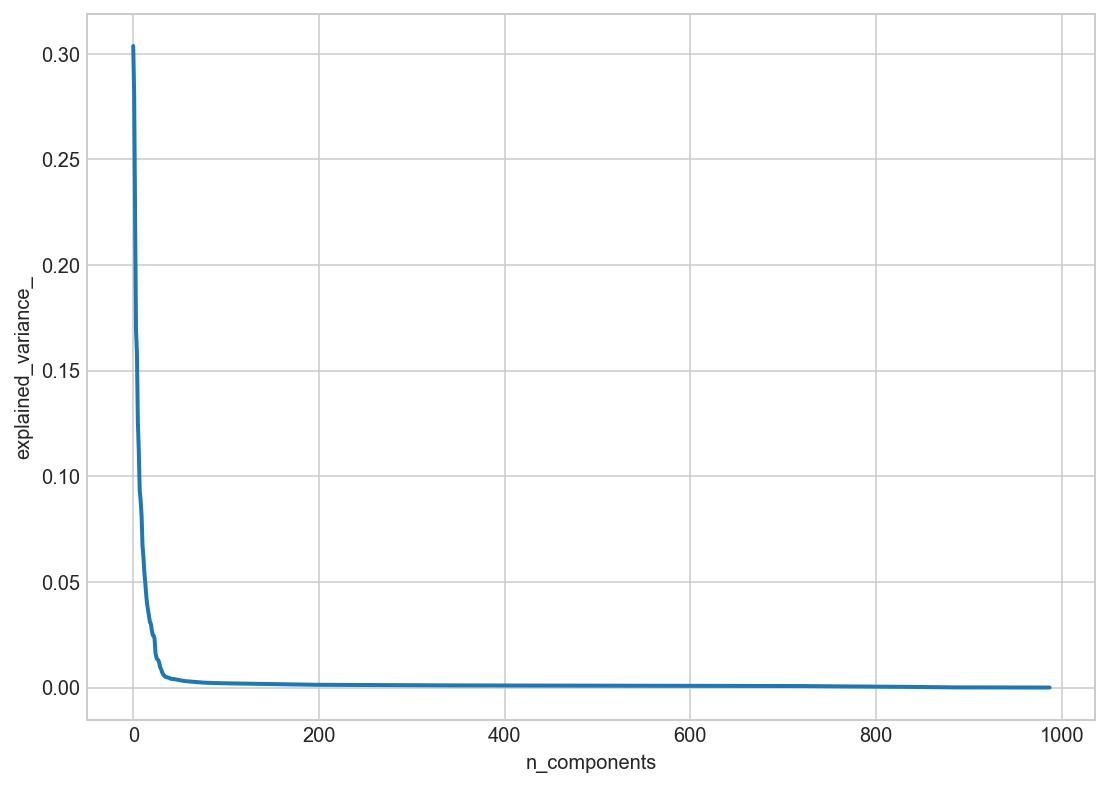

In [84]:
#Check for number of components to use
from sklearn import linear_model, decomposition, datasets
pca = decomposition.PCA()
# Plot the PCA spectrum
pca.fit(X_train_csr.todense())

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
#after 50 components, explained variance decreased significantly

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50) #select 50 eigenvectors
pca.fit(X_train_csr.todense())
print(pca.explained_variance_ratio_.sum()) #74% explained variance using 50 eigenvectors

0.7366247224206303


#### PCA effectively transforms 150,040 X features to 50 features while retaining 74% of data variance.

In [86]:
X_train_pcs = pca.transform(X_train_csr.todense())
X_train_pcs = pd.DataFrame(X_train_pcs, 
                       columns=['PC'+str(i+1) for i in range(50)])

X_train_pcs.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.195506  0.276760 -0.662884  0.744794 -0.317980  0.171825 -0.242824   
1  0.831821  0.562961  0.741962  0.481429 -0.417330  0.437152  0.110291   
2  0.599126  0.599280  0.421719  0.216401  0.761280 -0.282140  0.040963   
3 -0.419445 -0.668275  0.087993 -0.242207 -0.067483 -0.022519  0.119070   
4 -0.450874 -0.779424  0.078652 -0.341349 -0.062334  0.282240  0.559523   

        PC8       PC9      PC10    ...         PC41      PC42      PC43  \
0  0.165674 -0.350105  0.029135    ...    -0.144035 -0.007189  0.023701   
1 -0.117517 -0.015539 -0.261426    ...     0.025410 -0.023176  0.019445   
2 -0.093926 -0.136728 -0.201405    ...     0.026893  0.029201 -0.016453   
3  0.080965  0.063369 -0.083994    ...    -0.018403 -0.004121  0.039281   
4  0.125702 -0.516195 -0.226592    ...     0.022963 -0.022146 -0.012069   

       PC44      PC45      PC46      PC47      PC48      PC49      PC50  
0 -0.022306 -0.110883 -0.001051  0.082264 -0.059697 -0.009754 -0.016759  
1 -0.003050  0.036165  0.003282 -0.023196  0.014814 -0.022023  0.017574  
2  0.001048 -0.007826 -0.023536  0.044628 -0.008722  0.054666 -0.028012  
3 -0.030889 -0.000584  0.049473 -0.069993 -0.023283 -0.008952 -0.000501  
4 -0.034372  0.075123  0.001946 -0.075054 -0.012937 -0.035049  0.070088  

[5 rows x 50 columns]

In [87]:
#pca fit reset X_train_csr index, have to reset other y and test dataset index as well
y_train_pcs = y_train.reset_index(drop=True)
y_test_pcs = y_test.reset_index(drop=True)
X_test_pcs = pca.transform(X_test_csr.todense())
X_test_pcs = pd.DataFrame(X_test_pcs, 
                       columns=['PC'+str(i+1) for i in range(50)])

In [88]:
#simple linear regression gives score of 0.437. PCA fit not bad.
lr = LinearRegression()
scores = cross_val_score(lr, X_train_pcs, y_train_pcs, cv=5)
round(np.mean(scores),3), round(np.std(scores),3)

(0.437, 0.054)

In [89]:
#test score of linear regression.
lr = LinearRegression()
model = lr.fit(X_train_pcs, y_train_pcs)
model.score(X_test_pcs, y_test_pcs)

0.44087690472273333

In [90]:
#use a randomized search due to large number of parameters
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, n_jobs=4, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
rf_random.fit(X_train_pcs, y_train_pcs)
print rf_random.best_score_ #0.34638931931671324
print rf_random.best_estimator_ #{'min_samples_split': 5, 'max_features': 'sqrt', 'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.2min finished


0.3606619374586119
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [91]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
#test score
model = rf.fit(X_train_pcs, y_train_pcs)
model.score(X_test_pcs, y_test_pcs)

0.39888192683368945

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = XGBRegressor(learning_rate=0.02, n_estimators=600, objective='reg:linear',
                    silent=True, nthread=1)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, n_jobs=4, cv=3, verbose=2, random_state=42)
# Here we go
random_search.fit(X_train_pcs, y_train_pcs)
print(random_search.best_score_)
print(random_search.best_estimator_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   44.3s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.0min finished


0.4071589445754323
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.5, learning_rate=0.02,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)


In [93]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.02,
       max_delta_step=0, max_depth=4, min_child_weight=10, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

model = xgb.fit(X_train_pcs, y_train_pcs)
model.score(X_test_pcs, y_test_pcs)

0.47342048096241696

In [94]:
#further tune
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
        'min_child_weight': [8, 10, 12],
        'gamma': [0.1, 0.5, 0.7],
        'subsample': [0.4, 0.6],
        'colsample_bytree': [0.4, 0.6],
        'max_depth': [4]
        }
xgb = XGBRegressor(learning_rate=0.02, n_estimators=600, objective='reg:linear',
                    silent=True, nthread=1)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, n_jobs=4, cv=3, verbose=2, random_state=42)
# Here we go
random_search.fit(X_train_pcs, y_train_pcs)
print(random_search.best_score_)
print(random_search.best_estimator_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:   48.0s finished


0.4138356838840342
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.1, learning_rate=0.02,
       max_delta_step=0, max_depth=4, min_child_weight=8, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)


In [95]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.02,
       max_delta_step=0, max_depth=4, min_child_weight=8, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.4)

model = xgb.fit(X_train_pcs, y_train_pcs)
model.score(X_test_pcs, y_test_pcs)
#can continue to tune to get better results

0.47038101877237387

### Boosting is a plausible approach if computation efficiency can be achieved. PCA could help transform predictors into fewer features to reduce boosting computational burden.

QUESTION 2: Factors that distinguish job category
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

What components of a job posting distinguish data scientists from other data jobs?
What features are important for distinguishing junior vs. senior positions?
Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?
You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

## 1: Data Preparation with Categorical target variable

In [96]:
job_cat = df.columns[df.columns.str.contains('cat_')]

In [119]:
df.head()

Company  \
1                      HP PPS ASIA PACIFIC PTE. LTD.   
2                   SHOPEE SINGAPORE PRIVATE LIMITED   
3  PRICEWATERHOUSECOOPERS CONSULTING (SINGAPORE) ...   
4                                Company Undisclosed   
6                          JPMORGAN CHASE BANK, N.A.   

                                              Title  \
1                                  business analyst   
2                                 software engineer   
3                           data analytics –manager   
4                                   research fellow   
6  application support analyst, reference data team   

                                        Address  \
1                          1 DEPOT CLOSE 109841   
2          GALAXIS, 1 FUSIONOPOLIS PLACE 138522   
3  MARINA ONE EAST TOWER, 7 STRAITS VIEW 018936   
4                                           NaN   
6                                           NaN   

                         Emp_type                Seniority  \
1            Permanent, Full Time             Professional   
2            Permanent, Full Time                Executive   
3  Permanent, Contract, Full Time                  Manager   
4             Contract, Full Time  Professional, Executive   
6                       Full Time                Executive   

                 Industry           Salary  \
1                  Others  $8,400to$12,900   
2  Information Technology   $4,400to$8,000   
3             Consulting    $6,200to$9,500   
4                  Others   $4,000to$5,000   
6  Information Technology  $6,000to$12,000   

                                      Responsibility  \
1  HP is the world’s leading personal systems and...   
2  Responsibilities:   Develop and enhance data i...   
3   Advisory - Consulting  PwC Consulting is a re...   
4  Data Scientist / Programmer for Regional ATM M...   
6  We are seeking an Application Support Analyst ...   

                                        Requirements  Salary_lower  \
1  Education and Experience Required:   Prior exp...        8400.0   
2  Requirements:   Minimum B.S. degree in Compute...        4400.0   
3    A good Degree in a quantitative discipline (...        6200.0   
4   Doctorate degree in a relevant field. At leas...        4000.0   
6  Qualifications  7-10 years Production support ...        6000.0   

                         ...                          cat_Digital  \
1                        ...                                    0   
2                        ...                                    0   
3                        ...                                    0   
4                        ...                                    0   
6                        ...                                    0   

   cat_Consultant  cat_Intelligence  cat_Marketing  cat_Bigdata  cat_Project  \
1               0                 0              0            0            0   
2               0                 0              0            0            0   
3               0                 0              0            0            0   
4               0                 0              0            0            0   
6               0                 0              0            0            0   

   cat_Sales cat_HR cat_Others  \
1          0      0          0   
2          0      0          0   
3          0      0          0   
4          0      0          0   
6          0      0          0   

                                            job_text  
1  hp is the world s leading personal systems and...  
2  responsibilities develop and enhance data infr...  
3  advisory consulting pwc consulting is a region...  
4  data scientist programmer for regional atm mod...  
6  we are seeking an application support analyst ...  

[5 rows x 76 columns]

In [97]:
df[job_cat].sum() # pick top 4 multi-label categories to predict

cat_Analyst         354
cat_Engineer        169
cat_Analytics       118
cat_Scientist       114
cat_Research         70
cat_Developer        65
cat_Software         61
cat_Digital          58
cat_Consultant       64
cat_Intelligence     55
cat_Marketing        97
cat_Bigdata          34
cat_Project          39
cat_Sales            17
cat_HR               27
cat_Others          253
dtype: int64

In [98]:
#selected y labels
cat = df[job_cat].sum()[:4].index.values

In [99]:
#get similar engineered dataframe of qns 1 for qns 2
df_ind_w_ranks['job_text'] = df['job_text'] #industry, seniority, district dummies with job desc +req text
df2 = pd.concat([df_ind_w_ranks,df[cat]], axis=1) #add job_cat labels as target
df2.head() #new dataframe

Accounting / Auditing / Taxation  Admin / Secretarial  \
1                                 0                    0   
2                                 0                    0   
3                                 0                    0   
4                                 0                    0   
6                                 0                    0   

   Advertising / Media   Banking and Finance  Building and Construction  \
1                     0                    0                          0   
2                     0                    0                          0   
3                     0                    0                          0   
4                     0                    0                          0   
6                     0                    0                          0   

   Consulting   Customer Service  Design  Education and Training  Engineering  \
1            0                 0       0                       0            0   
2            0                 0       0                       0            0   
3            1                 0       0                       0            0   
4            0                 0       0                       0            0   
6            0                 0       0                       0            0   

       ...        districts_13.0  districts_22.0  districts_40.0  \
1      ...                     0               0               0   
2      ...                     1               0               0   
3      ...                     0               0               0   
4      ...                     0               0               0   
6      ...                     0               0               0   

   districts_48.0  districts_Others  \
1               0                 1   
2               0                 0   
3               0                 0   
4               0                 1   
6               0                 1   

                                            job_text  cat_Analyst  \
1  hp is the world s leading personal systems and...            1   
2  responsibilities develop and enhance data infr...            0   
3  advisory consulting pwc consulting is a region...            0   
4  data scientist programmer for regional atm mod...            0   
6  we are seeking an application support analyst ...            1   

   cat_Engineer  cat_Analytics  cat_Scientist  
1             0              0              0  
2             1              0              0  
3             0              1              0  
4             0              0              0  
6             0              0              0  

[5 rows x 60 columns]

In [100]:
#Train-test split
from sklearn.model_selection import train_test_split
X = df2.drop(cat, axis=1)
y = df2[cat]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #can add in stratify=y
print (y_train.sum(), y_train.sum()/float(len(y_train))*100)
print ''
print (y_test.sum(), y_test.sum()/float(len(y_test))*100)
#dataset is unbalanced

(cat_Analyst      283
cat_Engineer     135
cat_Analytics     95
cat_Scientist     92
dtype: int64, cat_Analyst      28.643725
cat_Engineer     13.663968
cat_Analytics     9.615385
cat_Scientist     9.311741
dtype: float64)

(cat_Analyst      71
cat_Engineer     34
cat_Analytics    23
cat_Scientist    22
dtype: int64, cat_Analyst      28.629032
cat_Engineer     13.709677
cat_Analytics     9.274194
cat_Scientist     8.870968
dtype: float64)


In [101]:
#write function to get model performance
def model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    #roc, auc for model for common performance measurement
    from sklearn.metrics import roc_curve, auc
    # For class 1, find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
    roc_auc = auc(fpr, tpr)
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for 1', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print 'auc:',roc_auc
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn import metrics
    
    #fit and predict
    class_fit = model.fit(X_train, y_train)
    class_pred = model.predict(X_test)
    #confusion matrix and f1-score
    conmat = np.array(confusion_matrix(y_test, class_pred))
    confusion = pd.DataFrame(conmat, index=[0,1], columns=['predicted_0','predicted_1'])
    f1_score = metrics.f1_score(y_test, class_pred, average='weighted')
    precision_score = metrics.precision_score(y_test, class_pred, average='weighted')
    print ''
    print 'Confusion Table:'
    print (confusion)
    print ''
    print 'Classification Report:'
    print (classification_report(y_test, class_pred))
    print 'f1:',f1_score
    print 'precision:',precision_score
    return roc_auc, f1_score, precision_score

## Try modelling on dummy columns to look at performance first

#### Try SVC

In [102]:
#choosing kernel for SVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=kernel, degree=3)
    scores = cross_val_score(svm, X_train.drop('job_text', axis=1), y_train.iloc[:,3], cv=5, scoring='roc_auc') #use 
    sm = scores.mean()
    ss = scores.std()
    print "{} - Average score: {:0.3} +/- {:0.3}".format(kernel,sm, ss)

linear - Average score: 0.619 +/- 0.0504
poly - Average score: 0.604 +/- 0.0722
rbf - Average score: 0.661 +/- 0.0656
sigmoid - Average score: 0.532 +/- 0.0277


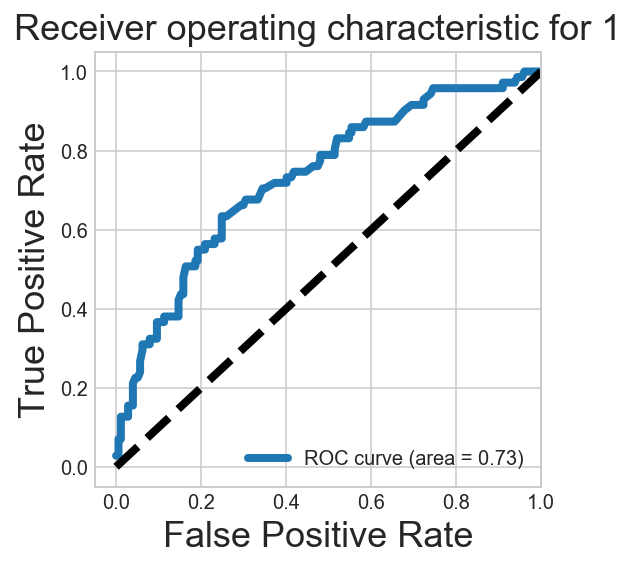

auc: 0.7334686082597279


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Confusion Table:
   predicted_0  predicted_1
0          177            0
1           71            0

Classification Report:
             precision    recall  f1-score   support

          0       0.71      1.00      0.83       177
          1       0.00      0.00      0.00        71

avg / total       0.51      0.71      0.59       248

f1: 0.5944781783681213
precision: 0.5093815036420396


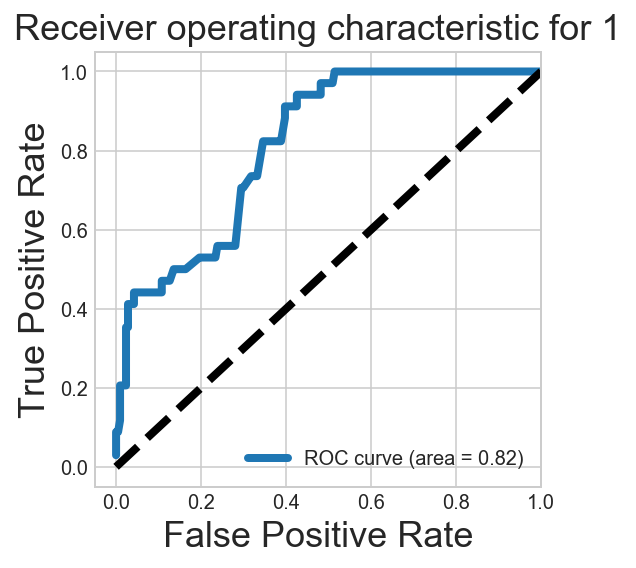

auc: 0.8156954370533261

Confusion Table:
   predicted_0  predicted_1
0          214            0
1           34            0

Classification Report:
             precision    recall  f1-score   support

          0       0.86      1.00      0.93       214
          1       0.00      0.00      0.00        34

avg / total       0.74      0.86      0.80       248

f1: 0.7993995252059769
precision: 0.74460197710718


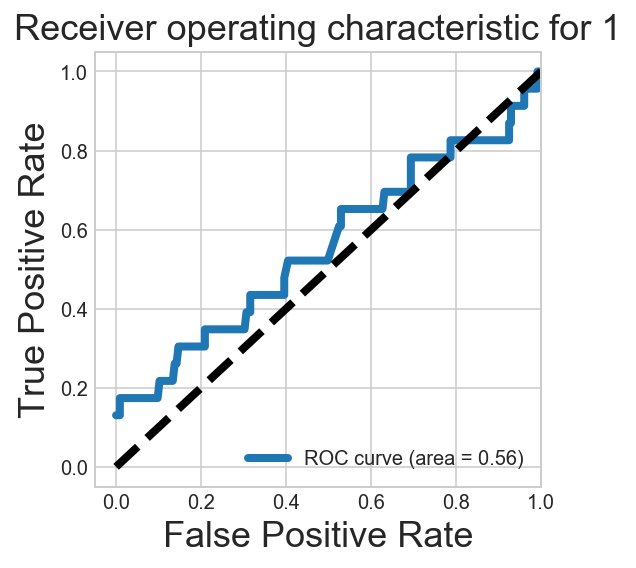

auc: 0.5577777777777777

Confusion Table:
   predicted_0  predicted_1
0          225            0
1           23            0

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       225
          1       0.00      0.00      0.00        23

avg / total       0.82      0.91      0.86       248

f1: 0.8631419218440973
precision: 0.8231171956295525


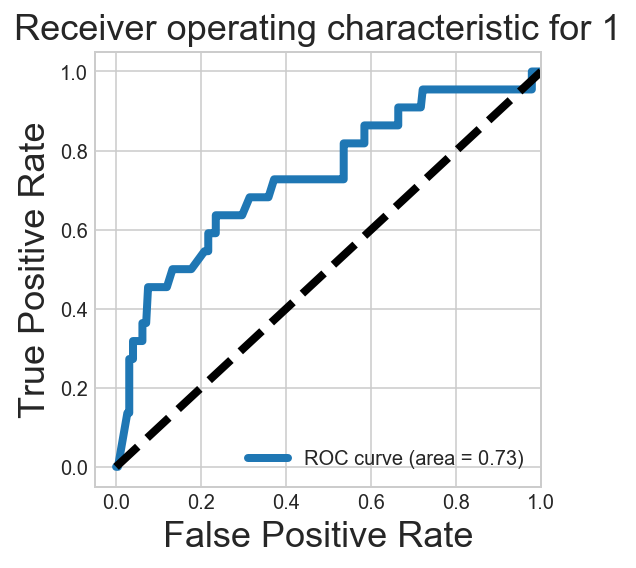

auc: 0.7344127111826226

Confusion Table:
   predicted_0  predicted_1
0          226            0
1           22            0

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       226
          1       0.00      0.00      0.00        22

avg / total       0.83      0.91      0.87       248

f1: 0.868994147270995
precision: 0.8304500520291362


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.733469      0.815695       0.557778       0.734413
f1        0.594478      0.799400       0.863142       0.868994
presc     0.509382      0.744602       0.823117       0.830450

In [103]:
svm = SVC(kernel='rbf', degree=3, probability=True)
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(svm, X_train.drop('job_text', axis=1), y_train.iloc[:,i], X_test.drop('job_text', axis=1), y_test.iloc[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

#### Try logistic models

In [104]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logreg = LogisticRegression()
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=5)
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=5)

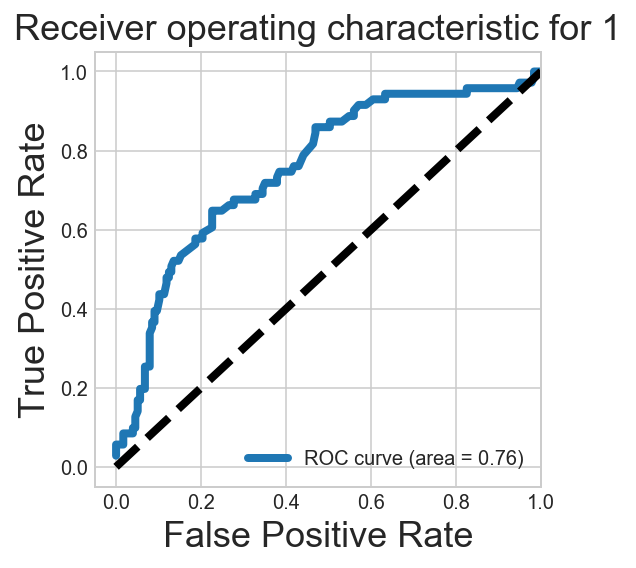

auc: 0.7554706771703668

Confusion Table:
   predicted_0  predicted_1
0          159           18
1           40           31

Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.90      0.85       177
          1       0.63      0.44      0.52        71

avg / total       0.75      0.77      0.75       248

f1: 0.7515328300160147
precision: 0.7513728947568653


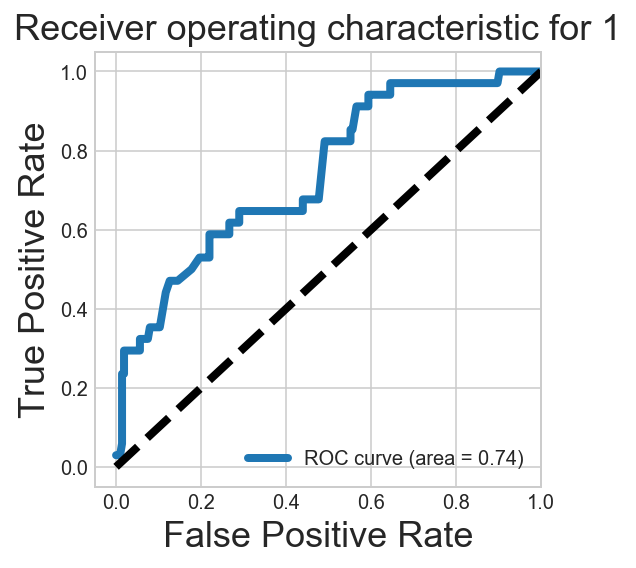

auc: 0.74326553051127

Confusion Table:
   predicted_0  predicted_1
0          206            8
1           24           10

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.96      0.93       214
          1       0.56      0.29      0.38        34

avg / total       0.85      0.87      0.85       248

f1: 0.8534415308608856
precision: 0.8490260246220976


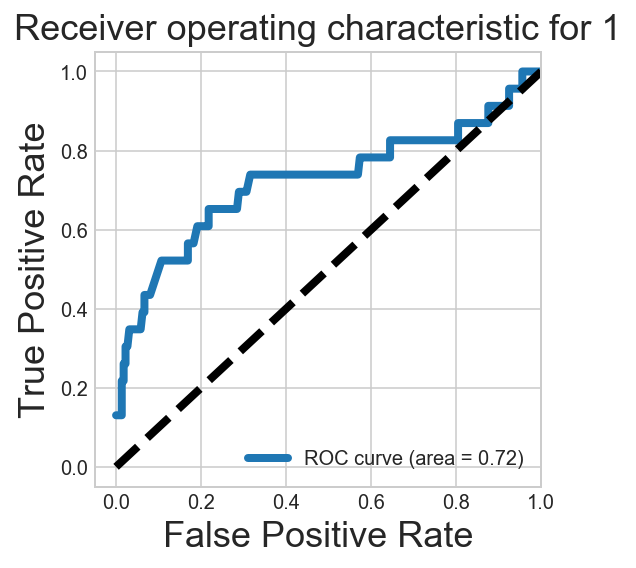

auc: 0.7236714975845412

Confusion Table:
   predicted_0  predicted_1
0          225            0
1           20            3

Classification Report:
             precision    recall  f1-score   support

          0       0.92      1.00      0.96       225
          1       1.00      0.13      0.23        23

avg / total       0.93      0.92      0.89       248

f1: 0.8900533234781692
precision: 0.9259381171823569


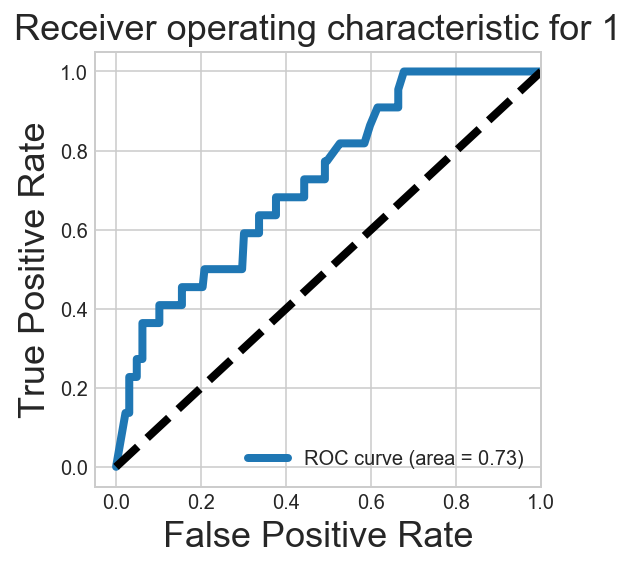

auc: 0.7265687851971039

Confusion Table:
   predicted_0  predicted_1
0          226            0
1           22            0

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       226
          1       0.00      0.00      0.00        22

avg / total       0.83      0.91      0.87       248

f1: 0.868994147270995
precision: 0.8304500520291362


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.755471      0.743266       0.723671       0.726569
f1        0.751533      0.853442       0.890053       0.868994
presc     0.751373      0.849026       0.925938       0.830450

In [105]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(lr_ridge, X_train.drop('job_text', axis=1), y_train.iloc[:,i], X_test.drop('job_text', axis=1), y_test.iloc[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

#### Try Naive Bayes models

In [106]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

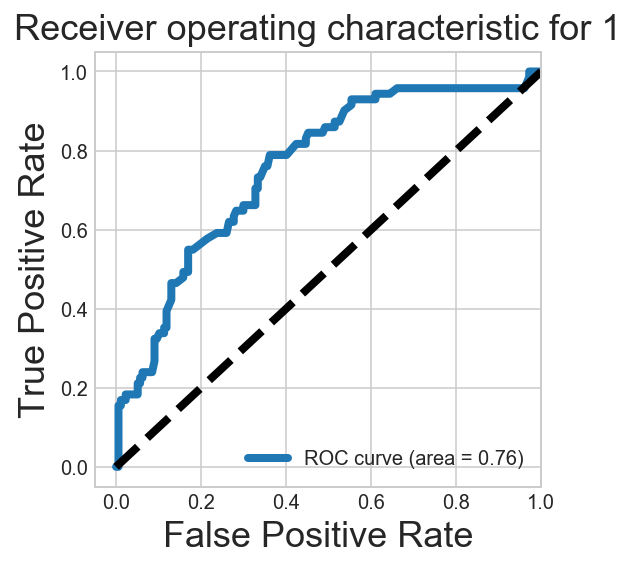

auc: 0.7583751094135434

Confusion Table:
   predicted_0  predicted_1
0          154           23
1           40           31

Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       177
          1       0.57      0.44      0.50        71

avg / total       0.73      0.75      0.73       248

f1: 0.7345136944613512
precision: 0.7309048947517521


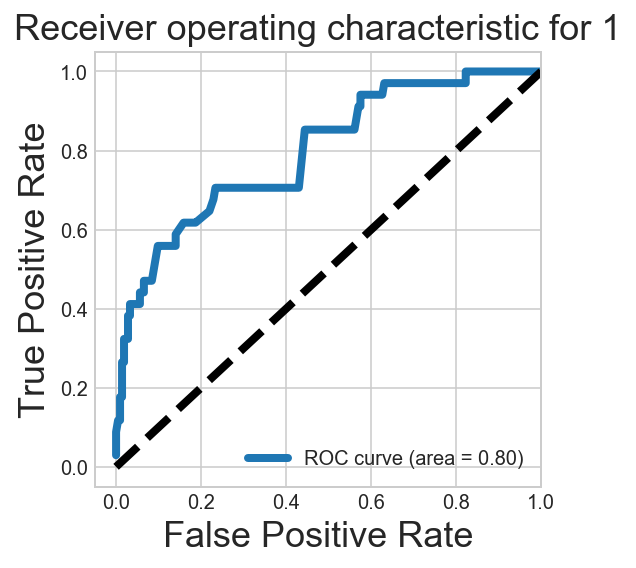

auc: 0.7978284771852666

Confusion Table:
   predicted_0  predicted_1
0          208            6
1           23           11

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.97      0.93       214
          1       0.65      0.32      0.43        34

avg / total       0.87      0.88      0.87       248

f1: 0.8658088679473238
precision: 0.8656961318251641


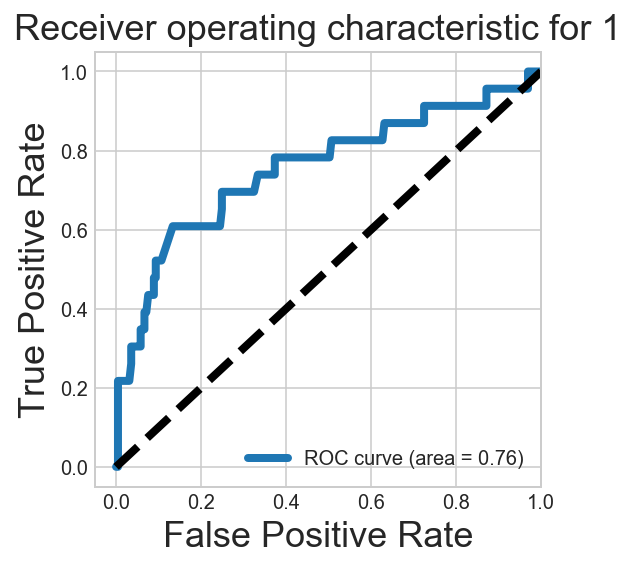

auc: 0.7562318840579709

Confusion Table:
   predicted_0  predicted_1
0          222            3
1           18            5

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.95       225
          1       0.62      0.22      0.32        23

avg / total       0.90      0.92      0.90       248

f1: 0.8962018730489075
precision: 0.8971774193548387


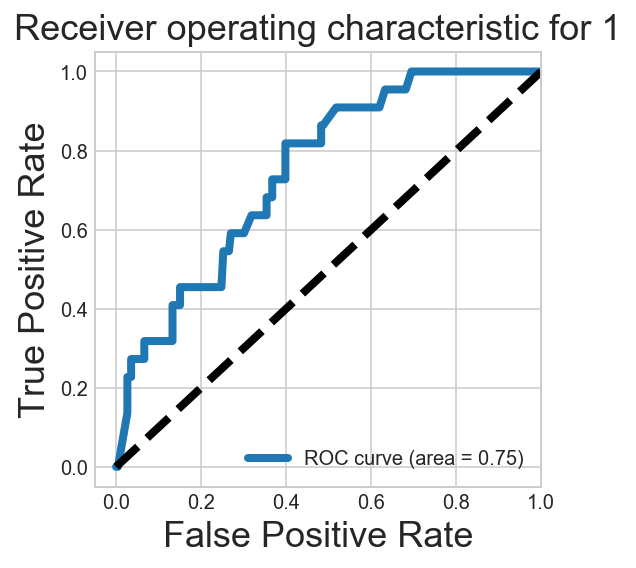

auc: 0.7494971842316975

Confusion Table:
   predicted_0  predicted_1
0          218            8
1           16            6

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.96      0.95       226
          1       0.43      0.27      0.33        22

avg / total       0.89      0.90      0.89       248

f1: 0.8933146330060776
precision: 0.886998306353145


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.758375      0.797828       0.756232       0.749497
f1        0.734514      0.865809       0.896202       0.893315
presc     0.730905      0.865696       0.897177       0.886998

In [107]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(BernoulliNB(), X_train.drop('job_text', axis=1), y_train.iloc[:,i], X_test.drop('job_text', axis=1), y_test.iloc[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

### SVM performs the worse on sparse/dummy predictors. 0 recall for all categories.
### BernoulliNB generally has higher metrics scores than the various logistic regressions.
### Though ridge logistic regression has higher precision, it comes at a cost of sig. lower recall rates.

In [108]:
#find top features from BernoulliNB which predict different job_cat
nb = BernoulliNB()

for i in range(4):  
    model = nb.fit(X_train.drop('job_text', axis=1), y_train.iloc[:,i])
    feat_lp = nb.feature_log_prob_
    p1 = np.exp(feat_lp[1])
    p0 = np.exp(feat_lp[0])
    feat_probs = pd.DataFrame({'p1':p1, 'p0':p0, 'feature':X_train.drop('job_text', axis=1).columns.values})
    feat_probs['prob_diff'] = feat_probs.p1 - feat_probs.p0
    feat_probs.sort_values('prob_diff', ascending=False, inplace=True)
    print ''
    print ('Top 5 features increase prob being in {}'.format(cat[i]))
    print feat_probs.head(5)
    print ''
    print ('Top 5 features decrease prob being in {}'.format(cat[i]))
    feat_probs.sort_values('prob_diff', ascending=True, inplace=True)
    print feat_probs.head(5)


Top 5 features increase prob being in cat_Analyst
                   feature        p0        p1  prob_diff
18  Information Technology  0.360679  0.585965   0.225286
3      Banking and Finance  0.135785  0.308772   0.172987
39        snr_avg_rank_5.0  0.111740  0.207018   0.095278
37        snr_avg_rank_3.0  0.168317  0.263158   0.094841
48           districts_6.0  0.067893  0.129825   0.061932

Top 5 features decrease prob being in cat_Analyst
                          feature        p0        p1  prob_diff
45               emp_avg_rank_2.0  0.796322  0.645614  -0.150708
9                     Engineering  0.111740  0.007018  -0.104722
42               snr_avg_rank_8.0  0.182461  0.080702  -0.101759
31    Sciences / Laboratory / R&D  0.087694  0.010526  -0.077168
22  Marketing / Public Relations   0.089109  0.014035  -0.075074

Top 5 features increase prob being in cat_Engineer
                   feature        p0        p1  prob_diff
9              Engineering  0.042105  0.328467   0

### Vectorize text columns in dataset

In [109]:
#lemmatize the text
import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
X_train_lem = X_train['job_text'].apply(lemmatize_text)
X_train_lem = X_train_lem.apply(lambda x: " ".join(x))
X_test_lem = X_test['job_text'].apply(lemmatize_text)
X_test_lem = X_test_lem.apply(lambda x: " ".join(x))

import scipy as sp
#cant use pipeline if we want the vectorized text col names
cvect = CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,3), max_df=0.9, min_df=1)
vect_text_df = TfidfTransformer().fit_transform(cvect.fit_transform(X_train_lem))
#csr sparse matrix of non-text and text
y_train_csr = y_train.values.astype(np.float32) 
X_train_csr = sp.sparse.hstack((vect_text_df, X_train.drop('job_text', axis=1).values),format='csr')
X_train_csr_cols = cvect.get_feature_names()+X_train.drop('job_text', axis=1).columns.tolist()
print X_train_csr.toarray()
print X_train_csr_cols[:10]

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[u'00', u'00 00', u'00 00 pm', u'00 00pm', u'00 00pm walking', u'00 pm', u'00 pm allows', u'000', u'000 000', u'000 000 graduate']


In [110]:
#csr test dataset as well
y_test_csr = y_test.values.astype(np.float32) 
X_test_csr = sp.sparse.hstack((vect_text.fit(X_train_lem).transform(X_test_lem),X_test.drop('job_text', axis=1).values),format='csr')

## 2: Modelling

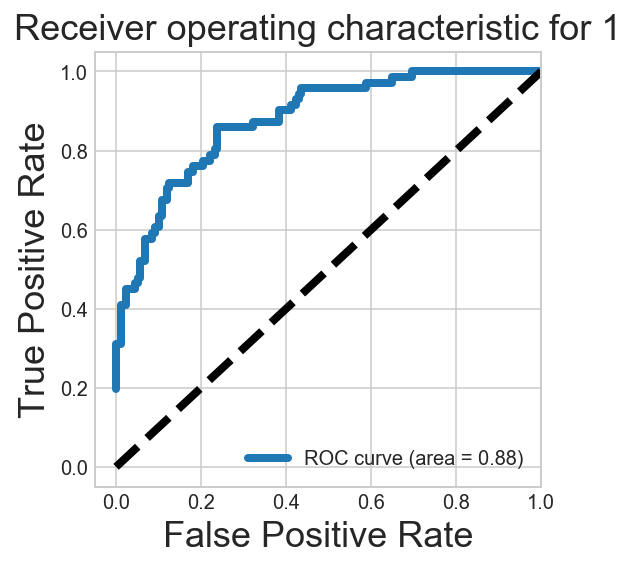

auc: 0.878968727619957

Confusion Table:
   predicted_0  predicted_1
0          177            0
1           56           15

Classification Report:
             precision    recall  f1-score   support

        0.0       0.76      1.00      0.86       177
        1.0       1.00      0.21      0.35        71

avg / total       0.83      0.77      0.72       248

f1: 0.7160960971950304
precision: 0.8284646268863354


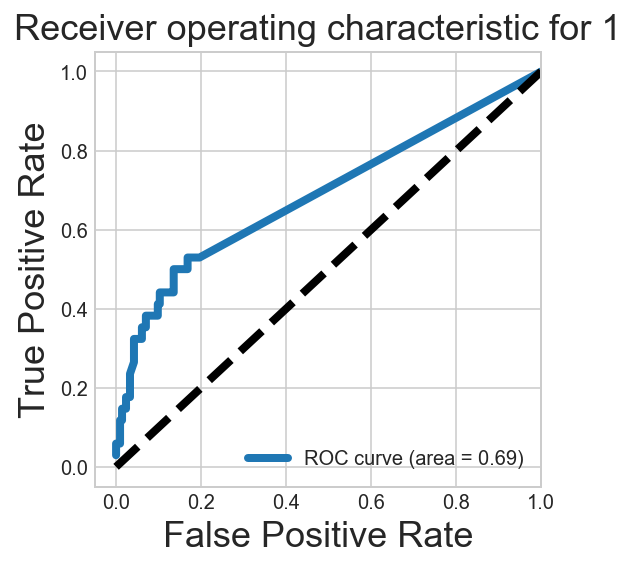

auc: 0.6887025838372732

Confusion Table:
   predicted_0  predicted_1
0          214            0
1           33            1

Classification Report:
             precision    recall  f1-score   support

        0.0       0.87      1.00      0.93       214
        1.0       1.00      0.03      0.06        34

avg / total       0.88      0.87      0.81       248

f1: 0.8089676819576757
precision: 0.8847133342039963


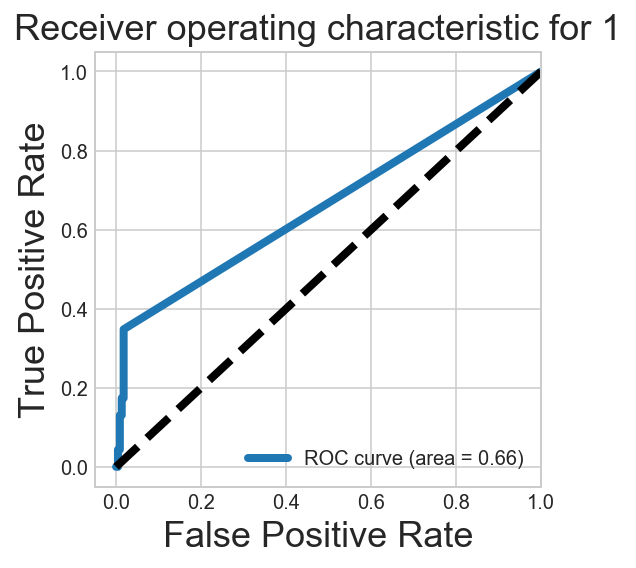

auc: 0.6634782608695652

Confusion Table:
   predicted_0  predicted_1
0          224            1
1           23            0

Classification Report:
             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95       225
        1.0       0.00      0.00      0.00        23

avg / total       0.82      0.90      0.86       248

f1: 0.8611262985237834
precision: 0.8227765443385138


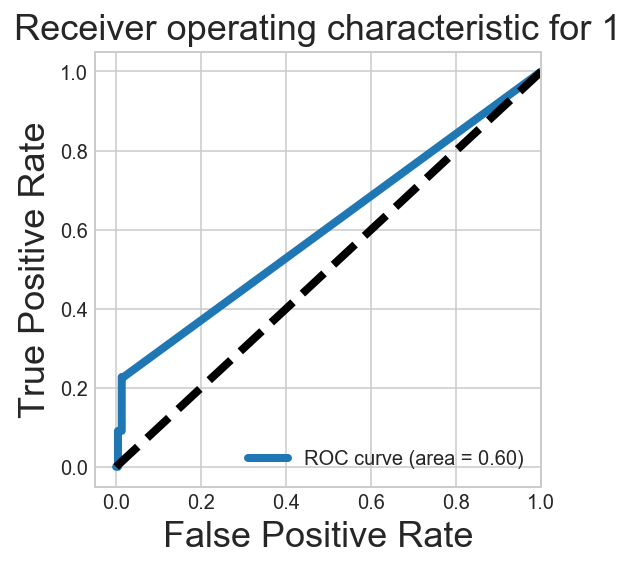

auc: 0.6045856798069187

Confusion Table:
   predicted_0  predicted_1
0          225            1
1           22            0

Classification Report:
             precision    recall  f1-score   support

        0.0       0.91      1.00      0.95       226
        1.0       0.00      0.00      0.00        22

avg / total       0.83      0.91      0.87       248

f1: 0.8669781081634045
precision: 0.8301227634843934


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.878969      0.688703       0.663478       0.604586
f1        0.716096      0.808968       0.861126       0.866978
presc     0.828465      0.884713       0.822777       0.830123

In [111]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(BernoulliNB(), X_train_csr, y_train_csr[:,i], X_test_csr, y_test_csr[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

### Naives Bayes performs worse off when text features are incorporated

#### Run gridsearch on largest class to select parameters.

In [112]:
#use a randomized search due to large number of parameters
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
rf_random.fit(X_train_csr, y_train_csr[:,0])
print rf_random.best_score_
print rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4, total=   0.3s
[CV] min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=4, total=   0.3s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4, total=   0.6s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4, total=   0.8s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=4, total=   0.8s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=False, ma

[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=100, min_samples_leaf=4, total=   0.1s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4 
[CV]  min_samples_split=5, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=False, max_depth=100, min_samples_leaf=4 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=False, max_depth=100, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=F

[CV]  min_samples_split=2, max_features=sqrt, bootstrap=True, max_depth=20, min_samples_leaf=4, total=   0.3s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=True, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=2, max_features=sqrt, bootstrap=True, max_depth=20, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=True, max_depth=20, min_samples_leaf=4 
[CV]  min_samples_split=2, max_features=sqrt, bootstrap=True, max_depth=20, min_samples_leaf=4, total=   0.3s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=60, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=60, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=60, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=60, min_samples_leaf=1, total=   0.2s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=True, max_

[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=1, total=   0.2s
[CV] min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=1 
[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=50, min_samples_leaf=1, total=   0.2s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1, total=   0.3s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1, total=   0.3s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=80, min_samples_leaf=1, total=   0.3s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=Fal

[CV]  min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=70, min_samples_leaf=4, total=   0.2s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1 
[CV]  min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1 
[CV]  min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1 
[CV]  min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=2, max_features=auto, bootstrap=True, max_depth=80, min_samples_leaf=4 
[CV]  min_samples_split=2, max_features=auto, bootstrap=True, max_depth=80, min_samples_leaf=4, total=   0.1s
[CV] min_samples_split=2, max_features=auto, bootst

[CV]  min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=1 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=1, total=   0.2s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=1 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=1, total=   0.2s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=T

[CV]  min_samples_split=5, max_features=sqrt, bootstrap=False, max_depth=80, min_samples_leaf=2, total=   0.3s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=False, max_depth=80, min_samples_leaf=2 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=False, max_depth=80, min_samples_leaf=2, total=   0.3s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2 
[CV]  min_samples_split=5, max_features=sqrt, bootstrap=True, max_depth=100, min_samples_leaf=2, total=   0.2s
[CV] min_samples_split=2, max_features=sqrt, bootstrap=True, 

[CV]  min_samples_split=2, max_features=sqrt, bootstrap=False, max_depth=100, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2, total=   0.4s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2, total=   0.4s
[CV] min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2 
[CV]  min_samples_split=10, max_features=auto, bootstrap=False, max_depth=50, min_samples_leaf=2, total=   0.5s
[CV] min_samples_split=10, max_features=sqrt, bootstrap=False, max_depth=70, min_samples_leaf=1 
[CV]  min_samples_split=10, max_features=sqrt, bootstrap=False, max_depth=70, min_samples_leaf=1, total=   0.4s
[CV] min_samples_split=10, max_features=sqrt, bootst

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.1min finished


0.8775047490377248
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [113]:
rf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

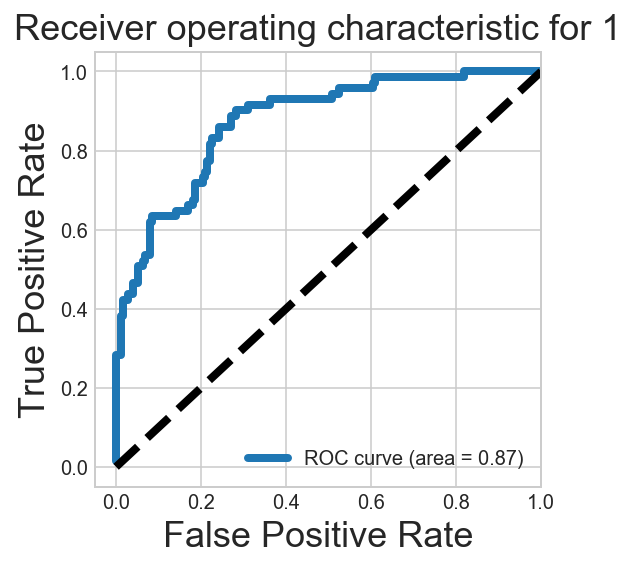

auc: 0.8745126123975492

Confusion Table:
   predicted_0  predicted_1
0          169            8
1           34           37

Classification Report:
             precision    recall  f1-score   support

        0.0       0.83      0.95      0.89       177
        1.0       0.82      0.52      0.64        71

avg / total       0.83      0.83      0.82       248

f1: 0.8174594578771736
precision: 0.8295663612126348


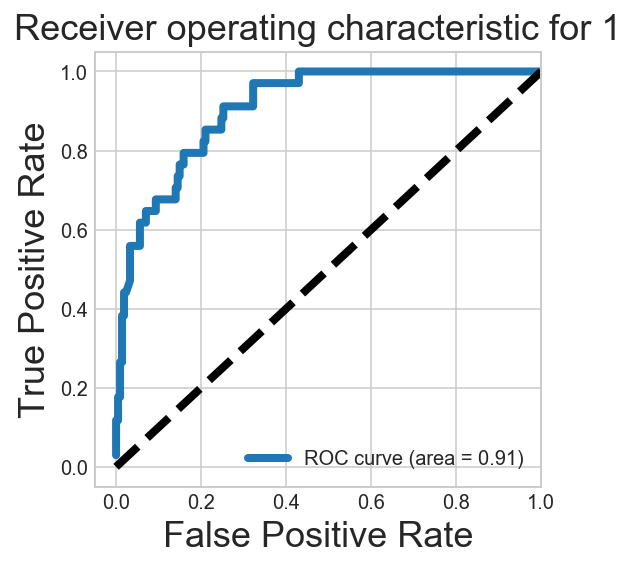

auc: 0.9083287520615723

Confusion Table:
   predicted_0  predicted_1
0          212            2
1           25            9

Classification Report:
             precision    recall  f1-score   support

        0.0       0.89      0.99      0.94       214
        1.0       0.82      0.26      0.40        34

avg / total       0.88      0.89      0.87       248

f1: 0.8660825405908018
precision: 0.8840497667569942


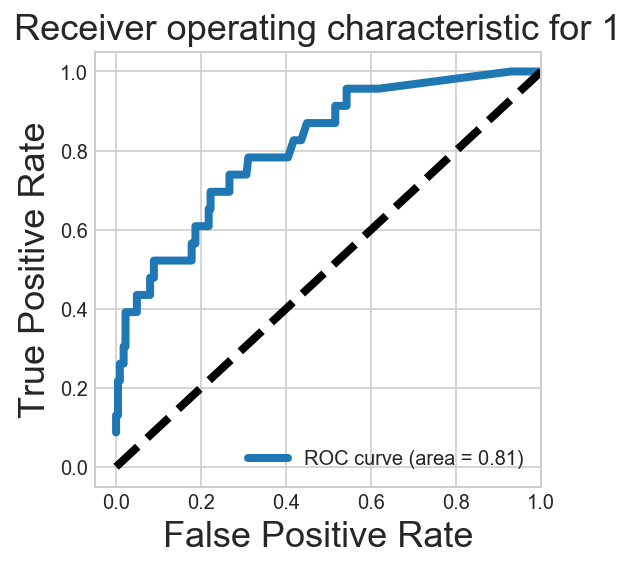

auc: 0.8103381642512077

Confusion Table:
   predicted_0  predicted_1
0          224            1
1           15            8

Classification Report:
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       225
        1.0       0.89      0.35      0.50        23

avg / total       0.93      0.94      0.92       248

f1: 0.9223442714126807
precision: 0.9327544577915747


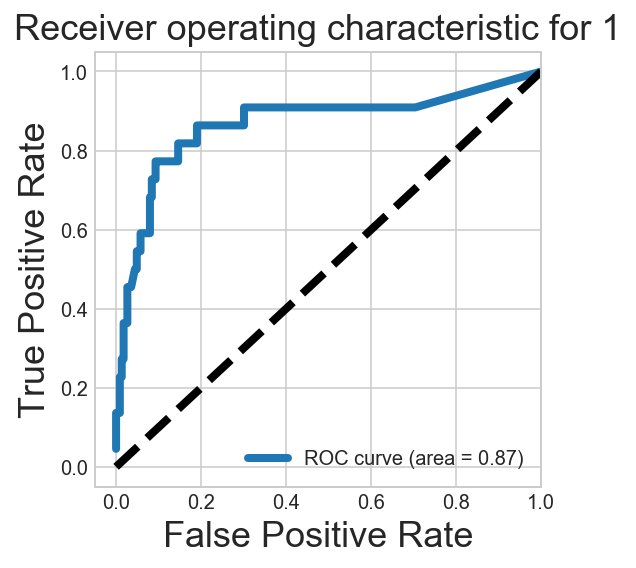

auc: 0.8662510056315367

Confusion Table:
   predicted_0  predicted_1
0          221            5
1           14            8

Classification Report:
             precision    recall  f1-score   support

        0.0       0.94      0.98      0.96       226
        1.0       0.62      0.36      0.46        22

avg / total       0.91      0.92      0.91       248

f1: 0.9142847146555774
precision: 0.9115912570614013


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.874513      0.908329       0.810338       0.866251
f1        0.817459      0.866083       0.922344       0.914285
presc     0.829566      0.884050       0.932754       0.911591

In [114]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(rf, X_train_csr, y_train_csr[:,i], X_test_csr, y_test_csr[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

## Randomforest incorporate information from text features well. Improving all metric scores.
### Try XGBoost next

In [115]:
#use a randomized search due to large number of parameters
random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring='roc_auc', n_jobs=4, n_iter = 5, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
xgb_random.fit(X_train_csr, y_train_csr[:,0])
print xgb_random.best_score_
print xgb_random.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.4min finished


0.8974976311482471
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)


In [116]:
#fit best parameters and get score
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

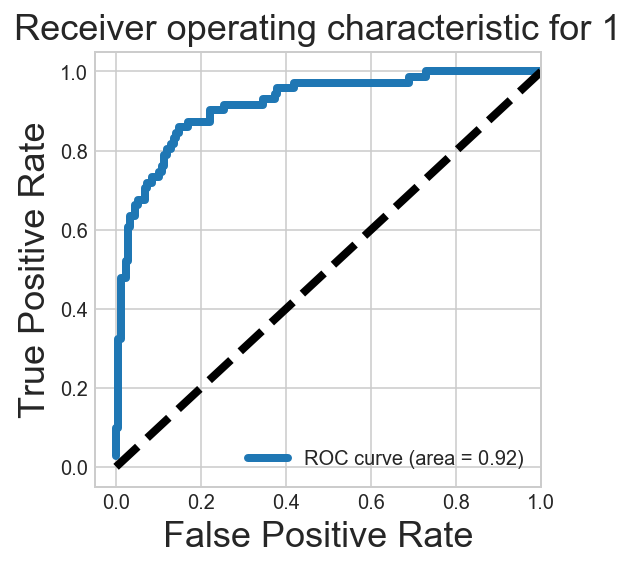

auc: 0.9174822948993395


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Confusion Table:
   predicted_0  predicted_1
0          164           13
1           21           50

Classification Report:
             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91       177
        1.0       0.79      0.70      0.75        71

avg / total       0.86      0.86      0.86       248

f1: 0.8603256662685502
precision: 0.8599085260375583


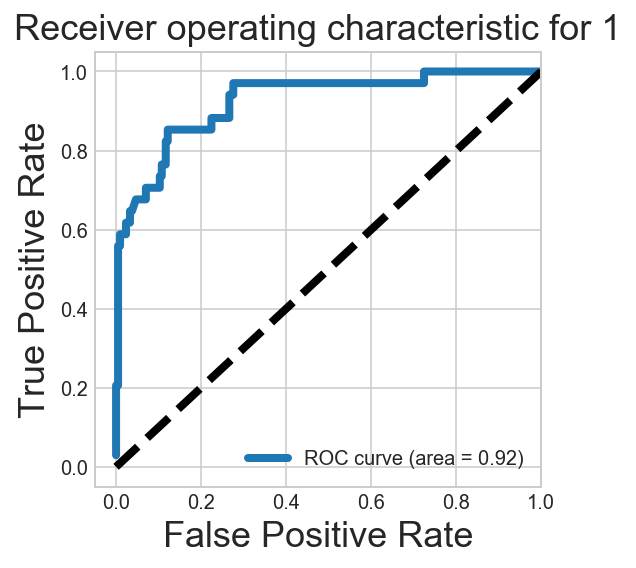

auc: 0.9248213304013193


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Confusion Table:
   predicted_0  predicted_1
0          208            6
1           13           21

Classification Report:
             precision    recall  f1-score   support

        0.0       0.94      0.97      0.96       214
        1.0       0.78      0.62      0.69        34

avg / total       0.92      0.92      0.92       248

f1: 0.9196077001160975
precision: 0.9187750368964791


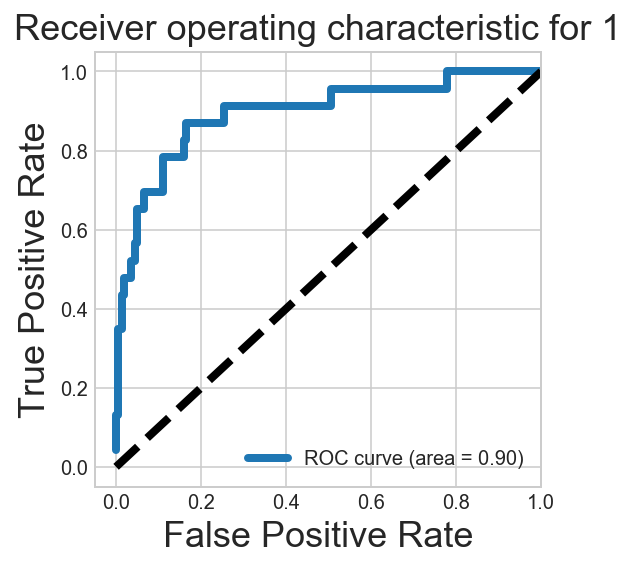

auc: 0.8958454106280194


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Confusion Table:
   predicted_0  predicted_1
0          224            1
1           17            6

Classification Report:
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96       225
        1.0       0.86      0.26      0.40        23

avg / total       0.92      0.93      0.91       248

f1: 0.9093105357884534
precision: 0.9227536952406448


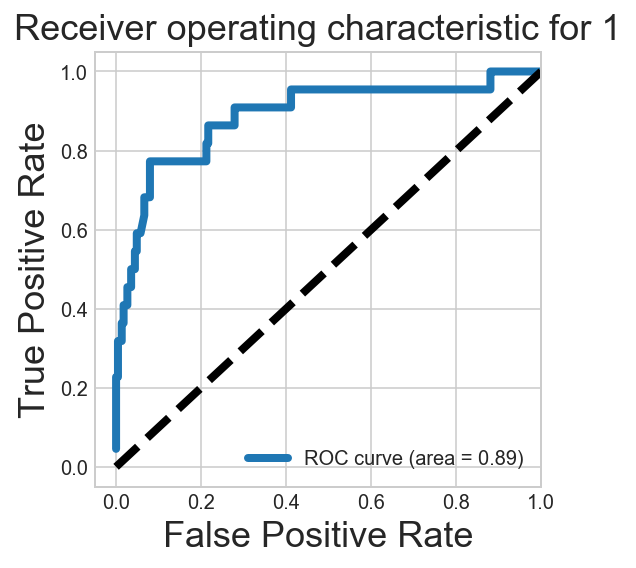

auc: 0.8871681415929205

Confusion Table:
   predicted_0  predicted_1
0          215           11
1            9           13

Classification Report:
             precision    recall  f1-score   support

        0.0       0.96      0.95      0.96       226
        1.0       0.54      0.59      0.57        22

avg / total       0.92      0.92      0.92       248

f1: 0.9209287829203678
precision: 0.92272705453149


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


cat_Analyst  cat_Engineer  cat_Analytics  cat_Scientist
auc       0.917482      0.924821       0.895845       0.887168
f1        0.860326      0.919608       0.909311       0.920929
presc     0.859909      0.918775       0.922754       0.922727

In [117]:
auc_ls = []
f1_ls = []
precision_ls = []
for i in range(4):  
    roc_auc, f1_score, precision_score = model_performance(xgb, X_train_csr, y_train_csr[:,i], X_test_csr, y_test_csr[:,i])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=cat, index=(['auc','f1','presc']))
metrics

## XGBoost performs the best! Highest metric scores with auc ~0.9 on avg.
## Conclusion:

### Qns1 - 
1. For continuous target with sparse nlp dataset, SVR seems to be a better choice model. However the best fit only explains 50% of salary variation, perhaps due to ~1200 size sample set. A plausible way to 'improve' model might be to categorize salaries into high-medium-low-etc and use classification models instead.
2. Seniority does play an important positive factor to improve salary. Strong key words such as risk, lead and banking pushes salary up as well. Geylang/Eunos industrial area is associated with lower salary. Admin, content and diploma are keywords predicting lower salary as well.
3. PCA could be a quick and dirty approach to limit no. of features while retaining most of the data information. This allows running of boosting models quickly but at a cost of features interpretability.

### Qns2 - 
1. Ensembles are able to incorporate large information for nlp classification well and are able to treat unbalanced dataset well.
2. If features are limited, simpler models like Naives Bayes could be sufficient.
3. Finally, the plot below shows important factors that are good predictors for different job categories (according to XGBoost). A caveat exist as we are not sure whether these features has a positive or negative effect on determining job cat, just that these features help increase node purity across decision tree splits.

In general, pipelines and csr for sparse matrix are useful to improve computation speed.

Top 10 important features for cat_Analyst


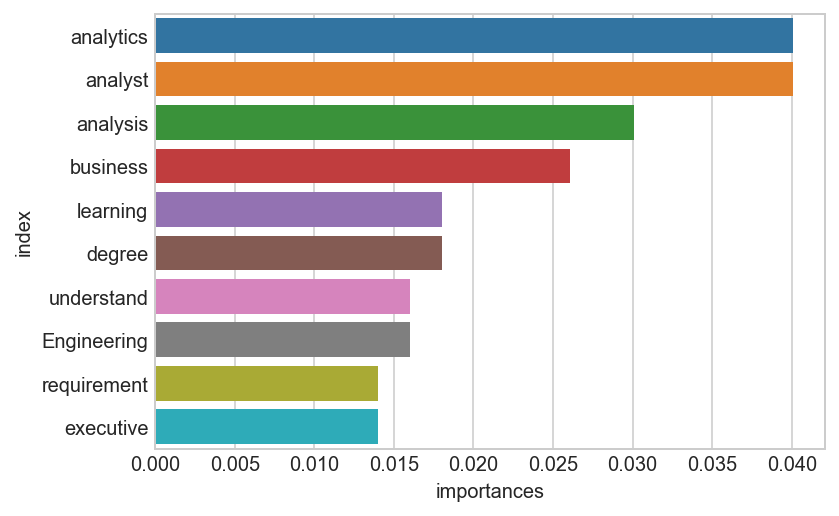

Top 10 important features for cat_Engineer


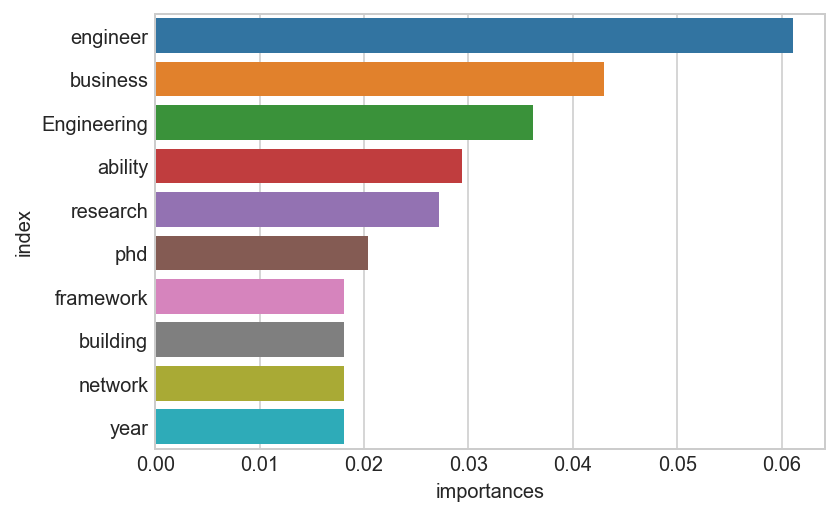

Top 10 important features for cat_Analytics


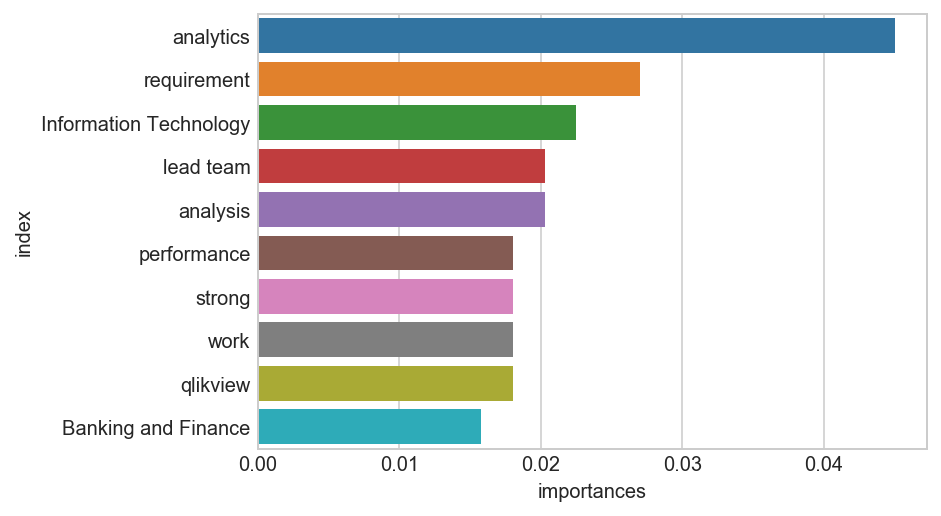

Top 10 important features for cat_Scientist


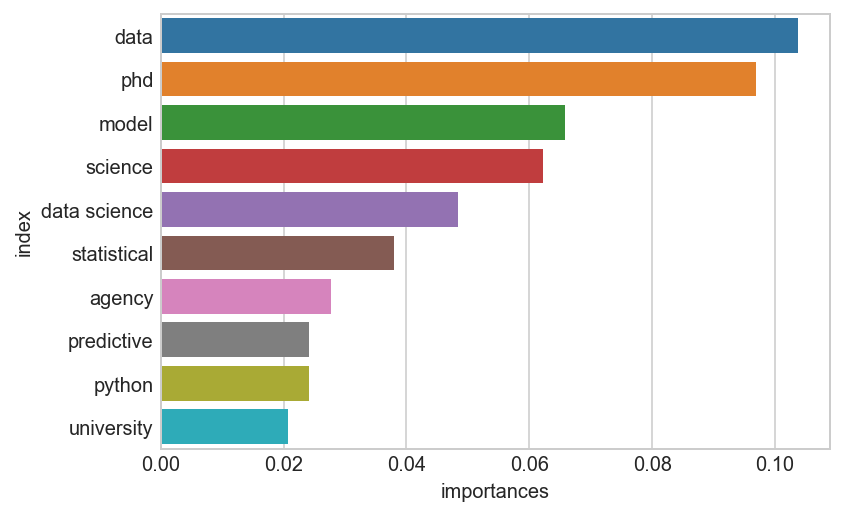

In [118]:
for i in range(4):
    xgb.fit(X_train_csr, y_train_csr[:,i])
    importances = xgb.feature_importances_
    fea_imp = pd.DataFrame(importances, X_train_csr_cols, columns = ['importances'])
    fea_imp = fea_imp.sort_values('importances', ascending=False).reset_index()
    print ('Top 10 important features for {}'.format(cat[i]))
    sns.barplot('importances', 'index', data=fea_imp[:10])
    plt.show()